NOTE: to run the notebook you need to change the path to the measured statistics (`Pk_true`, `Pk_int`, and `Bk_int`) in `outbox-all-fs-RSD-BSQ.csv` and `inbox-all-fs-RSD-BSQ.csv` to the path on your machine.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
sys.path.append("../src/training/")
import NoInterNet_model as NIN
import NoInterNet_fraction_model as NINf

import torch

from torch.utils.data import DataLoader
from torch import nn

from plotting_results import *

In [2]:
from matplotlib.pyplot import rc
import matplotlib.font_manager
rc('font',**{'size':'22','family':'serif','serif':['CMU serif']})
rc('mathtext', **{'fontset':'cm'})
rc('text', usetex=True)
rc('legend',**{'fontsize':'18'})
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['legend.fontsize'] = 15
#matplotlib.rcParams['legend.title_fontsize'] = 25
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.minor.size'] = 2.5
matplotlib.rcParams['ytick.minor.size'] = 2.5
matplotlib.rcParams['xtick.major.width'] = 1.5
matplotlib.rcParams['ytick.major.width'] = 1.5
matplotlib.rcParams['xtick.minor.width'] = 1.5
matplotlib.rcParams['ytick.minor.width'] = 1.5
matplotlib.rcParams['axes.titlesize'] = 30
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running on", device)

Running on cpu


In [4]:
def plot_fraction_cosmocolor(test, model, lenk, device, cosmo_ind, cosmo_name, norm_fs=False, pole=False, max_corr=None, min_corr=None, save=None):

    from matplotlib import colors, cm

    test_dataloader_all = DataLoader(test, batch_size=len(test), shuffle=True)

    sc = cm.ScalarMappable(norm=colors.Normalize(vmax=max_corr[cosmo_ind], vmin=min_corr[cosmo_ind]),
                       cmap='viridis')
    fig, ax = plt.subplots()

    for X, y, n in test_dataloader_all:
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
    
        j = 2 if pole else 1
        f_true = y.detach().numpy()[:,lenk * j]
        f_pred = pred.detach().numpy()[:,lenk * j]
        f_erro = pred.detach().numpy()[:,-1]

        if norm_fs:
            f_true = NINf.inv_minmax(f_true)
            f_pred = NINf.inv_minmax(f_pred)
            f_erro *= 0.1

        if max_corr is not None:
            cosmology = NINf.inv_maxmin_corr(X.detach().numpy(), max_corr, min_corr)

        cosmo = cosmology[:,cosmo_ind]
        
        for i, c in enumerate(cosmo):
            color = sc.to_rgba(c)
            plt.errorbar([f_true[i],], [f_pred[i],], yerr=np.sqrt(f_erro[i]**2), color=color, ecolor='tab:orange', capsize=2, elinewidth=.5, marker='.', linestyle='', alpha=.7)
    
    
    plt.plot([.01, .11], [.01, .11], linestyle='dashed', color='k')
    plt.xlabel('True fraction')
    plt.ylabel('Measured fraction')

    cbar = fig.colorbar(
          sc,
          label=cosmo_name,
          ax=ax,
      )
    
    if save is not None:
        plt.savefig(save, bbox_inches='tight', dpi=300)

    plt.show()

    print('MSE error:', np.mean((f_true - f_pred)**2))

def chi2(test, model, lenk, device, norm_fs=False, pole=False, reduced=True, thresh=1e-6):

    test_dataloader_all = DataLoader(test, batch_size=len(test), shuffle=True)

    for X, y, n in test_dataloader_all:
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
    
        j = 2 if pole else 1
        f_true = y.detach().numpy()[:,lenk * j]
        f_pred = pred.detach().numpy()[:,lenk * j]
        f_erro = pred.detach().numpy()[:,-1]

        if norm_fs:
            f_true = NINf.inv_minmax(f_true)
            f_pred = NINf.inv_minmax(f_pred)
            f_erro *= 0.1
    
    #sel = ((f_true - f_pred)**2 / f_erro**2) < thresh
    #print(np.sum(np.invert(sel)))
    sel = np.sqrt(f_erro**2) > thresh
    print(np.sum(np.invert(sel)))

    chi_square = np.sum((f_true[sel] - f_pred[sel])**2 / f_erro[sel]**2)

    if reduced: print('Reduced chi2:', chi_square / len(test))
    else: print('chi2:', chi_square)


Network input: $$P_{\rm inter}(k)/{\rm max}(P_{\rm inter}(k))$$
Network label: $$y(k) = \frac{P_{\rm true}(k)}{P_{\rm inter}(k)}$$
Network corrected power spectrum: $$P_{\rm corrected}(k) = y_{\rm pred}(k) \, P_{\rm inter}(k)$$
Relative error before correction: $$\frac{P_{\rm true}(k) - P_{\rm inter}(k)}{P_{\rm true}(k)} = 1 - \frac{P_{\rm inter}(k)}{P_{\rm true}(k)} = 1 - \frac{1}{y(k)}$$
Relative error after correction: $$\frac{P_{\rm true}(k) - P_{\rm corrected}(k)}{P_{\rm true}(k)} = 1 - \frac{P_{\rm corrected}(k)}{P_{\rm true}(k)} = 1 - \frac{P_{\rm corrected}(k)}{P_{\rm inter}(k)} \frac{P_{\rm inter}(k)}{P_{\rm true}(k)} = 1 - \frac{y_{\rm pred}(k)}{y_(k)}$$

# Outbox

In [5]:
N = np.array([512,1024,2048,4096,8192,16384,2**15])

## Compare Loss

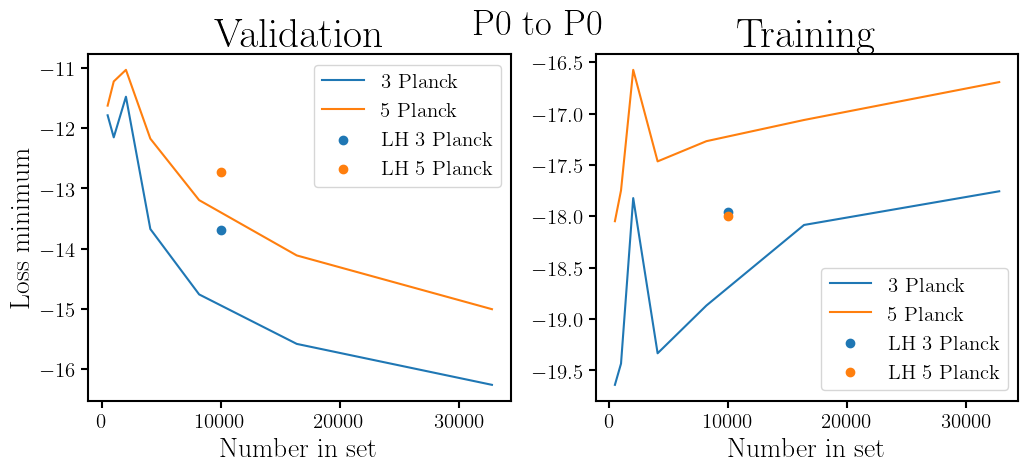

In [6]:
path = '../trained-model/BSQ/RSD/outbox/'

h_val3 = []
h_train3 = []
h_val5 = []
h_train5 = []
for i in N:
    name = path + f'NoInterNet-Logloss-P0-P0-allprior3P-BSQ-moments' if i == 2**15 else path + f'NoInterNet-Logloss-P0-P0-allprior3P-{i:d}-moments'
    name += '/history.dat'
    history_t, history_v = np.loadtxt(name, unpack=True)

    h_val3.append(np.min(history_v))
    h_train3.append(np.min(history_t))

    name = path + f'NoInterNet-Logloss-P0-P0-allprior5P-BSQ-moments' if i == 2**15 else path + f'NoInterNet-Logloss-P0-P0-allprior5P-{i:d}-moments'
    name += '/history.dat'
    history_t, history_v = np.loadtxt(name, unpack=True)

    h_val5.append(np.min(history_v))
    h_train5.append(np.min(history_t))

t, v = np.loadtxt('../trained-model/LH/RSD/outbox-1321.00-iz1/NoInterNet-Logloss-P0-P0-allprior3P-allshift-moments/history.dat', unpack=True)
LH_val3 = np.min(v)
LH_train3 = np.min(t)

t, v = np.loadtxt('../trained-model/LH/RSD/outbox-1321.00-iz1/NoInterNet-Logloss-P0-P0-allprior5P-allshift-moments/history.dat', unpack=True)
LH_val5 = np.min(v)
LH_train5 = np.min(t)

fig, ax = plt.subplots(1,2,figsize=(6*2,4.5))

ax[0].plot(N, h_val3, label='3 Planck')
ax[0].plot(N, h_val5, label='5 Planck')

ax[0].scatter(10000, LH_val3, label='LH 3 Planck')
ax[0].scatter(10000, LH_val5, label='LH 5 Planck')

ax[0].set_xlabel('Number in set')
ax[0].set_ylabel('Loss minimum')
ax[0].legend()
ax[0].set_title('Validation')


ax[1].plot(N, h_train3, label='3 Planck')
ax[1].plot(N, h_train5, label='5 Planck')

ax[1].scatter(10000, LH_train3, label='LH 3 Planck')
ax[1].scatter(10000, LH_train5, label='LH 5 Planck')

ax[1].set_xlabel('Number in set')
#ax[1].set_ylabel('Loss minimum')
ax[1].legend()
ax[1].set_title('Training')

plt.suptitle('P0 to P0')

plt.show()

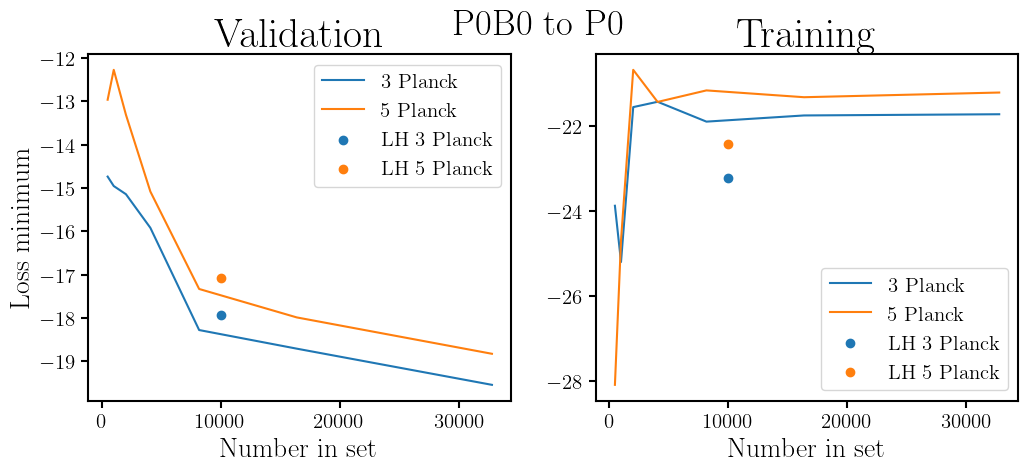

In [7]:
path = '../trained-model/BSQ/RSD/outbox/'

h_val3 = []
h_train3 = []
h_val5 = []
h_train5 = []
for i in N:
    name = path + f'NoInterNet-Logloss-P0B0-P0-allprior3P-BSQ-moments' if i == 2**15 else path + f'NoInterNet-Logloss-P0B0-P0-allprior3P-{i:d}-moments'
    name += '/history.dat'
    history_t, history_v = np.loadtxt(name, unpack=True)

    h_val3.append(np.min(history_v))
    h_train3.append(np.min(history_t))

    name = path + f'NoInterNet-Logloss-P0B0-P0-allprior5P-BSQ-moments' if i == 2**15 else path + f'NoInterNet-Logloss-P0B0-P0-allprior5P-{i:d}-moments'
    name += '/history.dat'
    history_t, history_v = np.loadtxt(name, unpack=True)

    h_val5.append(np.min(history_v))
    h_train5.append(np.min(history_t))

t, v = np.loadtxt('../trained-model/LH/RSD/outbox-1321.00-iz1/NoInterNet-Logloss-P0B0-P0-allprior3P-allshift-moments/history.dat', unpack=True)
LH_val3 = np.min(v)
LH_train3 = np.min(t)

t, v = np.loadtxt('../trained-model/LH/RSD/outbox-1321.00-iz1/NoInterNet-Logloss-P0B0-P0-allprior5P-allshift-moments/history.dat', unpack=True)
LH_val5 = np.min(v)
LH_train5 = np.min(t)

fig, ax = plt.subplots(1,2,figsize=(6*2,4.5))

ax[0].plot(N, h_val3, label='3 Planck')
ax[0].plot(N, h_val5, label='5 Planck')

ax[0].scatter(10000, LH_val3, label='LH 3 Planck')
ax[0].scatter(10000, LH_val5, label='LH 5 Planck')

ax[0].set_xlabel('Number in set')
ax[0].set_ylabel('Loss minimum')
ax[0].legend()
ax[0].set_title('Validation')


ax[1].plot(N, h_train3, label='3 Planck')
ax[1].plot(N, h_train5, label='5 Planck')

ax[1].scatter(10000, LH_train3, label='LH 3 Planck')
ax[1].scatter(10000, LH_train5, label='LH 5 Planck')

ax[1].set_xlabel('Number in set')
#ax[1].set_ylabel('Loss minimum')
ax[1].legend()
ax[1].set_title('Training')

plt.suptitle('P0B0 to P0')

plt.show()

## P0 -> P0

### 0 Planck prior

79
1 64 32
2 32 16
3 16 32
4 32 64
32768


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

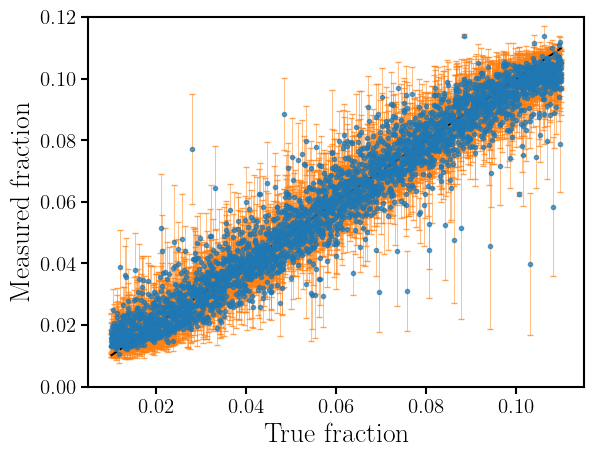

MSE error: 5.3386277e-05
3
Reduced chi2: 0.9609915879138694


In [8]:
j = 2**15
Pks, labels, lenk = NINf.load_Pkf("outbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, n_load=j)
print(lenk)
max_corr = labels[:,:-1].max(axis=0)
min_corr = labels[:,:-1].min(axis=0)

Pks, labels, lenk = NINf.load_Pkf("outbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, norm_c=True, n_load=j)

##Priors
Pk_paths = pd.read_csv("outbox_all-fs-RSD-BSQ.csv")

sP = {'sigma_8': 0.0060, 'Omega_m': 0.0056, 'h': 0.0042, 'n_s': 0.0038, 'Omega_b': 0.0008} #from Table 2 in Planck 2018 (1807.06209)
priors = ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
len_priors = len(priors)
np.random.seed(j) #for reproducibility of the MSE and plots
r = np.random.normal(size=(len(Pks), len_priors))
cosmo_p = np.zeros((len(Pks), len_priors))

for i, prior in enumerate(priors):
    if len_priors == 1:
        cosmo_p = np.reshape(Pk_paths[prior],((len(Pks),1))) + r * sP[prior] * 0. #0 times Planck
    else:
        cosmo_p[:,i] = Pk_paths[prior][:j] + r[:,i] * sP[prior] * 0. #0 times Planck

Pks = np.hstack((Pks, cosmo_p)) #I also normalize cosmo_p between 0 and 1
#Loading max min

n = f'NoInterNet-Logloss-P0-P0-allprior0P-{j:d}-moments' if j != 2**15 else 'NoInterNet-Logloss-P0-P0-allprior0P-BSQ-moments'

min_Pks, max_Pks = np.loadtxt("../trained-model/BSQ/RSD/outbox/" + n + "/maxmin.dat", unpack=True)
Pks = NINf.maxmin_corr(Pks, max_Pks, min_Pks)
norm = np.ones(len(Pks))

fs = labels[:,-1]

_, ind = np.unique(fs, return_index=True)
f_u = np.array([fs[indx] for indx in sorted(ind)]) #non ordered unique interloper fraction array

n_train = int(len(f_u)*0.75)
n_val = int(len(f_u)*0.9)

fs_test = (f_u[n_val:])

sel_test = np.array([], dtype=int)

for f in fs_test: sel_test= np.append(sel_test, np.where(fs == f)[0])

Pks_test = Pks[sel_test]
labels_test = labels[sel_test]

norm_test = np.array(norm[sel_test, np.newaxis])

test = NIN.PkDataset(Pks_test, labels_test, norm_test)

test_batch = 10
test_dataloader = DataLoader(test, batch_size=test_batch, shuffle=True)
model = NINf.NoInterNet_fraction_compress_inference(lenk+5, 64, lenk, 64, n_min=16).to(device)
NIN.resume(model, "../trained-model/BSQ/RSD/outbox/" + n + "/best_model-64.pth", device)
print(j)
plot_fraction(test, model, lenk=lenk, device=device, norm_fs=True, save=None)
chi2(test, model, lenk=lenk, device=device, norm_fs=True, thresh=1e-3)

/tmp/ipykernel_51685/3810797402.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.,0.6)


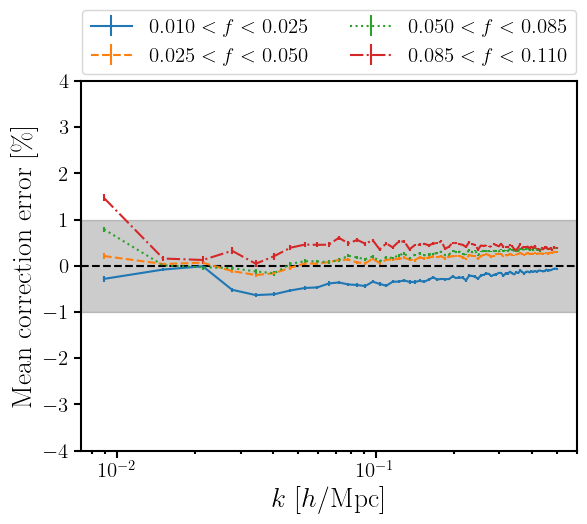

In [9]:
ks = np.loadtxt('ks-gris.dat')

p_mean1, y_mean1, std_mean1, m1, sm1, N1 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.001, 0.025, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean2, y_mean2, std_mean2, m2, sm2, N2 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.025, 0.050, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean3, y_mean3, std_mean3, m3, sm3, N3 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.050, 0.085, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean4, y_mean4, std_mean4, m4, sm4, N4 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.085, 0.110, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)

sel = (ks> 0.) & (ks < 0.5)
k_plot = ks[sel]

plt.errorbar(k_plot, m1[:lenk] * 100., yerr=sm1[:lenk]*100., label='$0.010 < f < 0.025$', linestyle='solid')
plt.errorbar(k_plot, m2[:lenk] * 100., yerr=sm2[:lenk]*100., label='$0.025 < f < 0.050$', linestyle='dashed')
plt.errorbar(k_plot, m3[:lenk] * 100., yerr=sm3[:lenk]*100., label='$0.050 < f < 0.085$', linestyle='dotted')
plt.errorbar(k_plot, m4[:lenk] * 100., yerr=sm4[:lenk]*100., label='$0.085 < f < 0.110$', linestyle='dashdot')

plt.axhline(0, color='k', linestyle='dashed')
plt.xscale('log')
plt.xlabel('$k$ [$h$/Mpc]')
plt.ylim(-4.,4.)
plt.xlim(0.,0.6)
plt.ylabel('''Mean correction error [$\\%$]''')

plt.fill_between([0., .6], -1, 1, alpha=.2, color='k')

plt.legend(ncols=2, loc='lower center', bbox_to_anchor=(0.5,0.99))
#plt.tight_layout()
plt.show()

### 1 Planck prior

79
1 64 32
2 32 16
3 16 32
4 32 64
32768


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

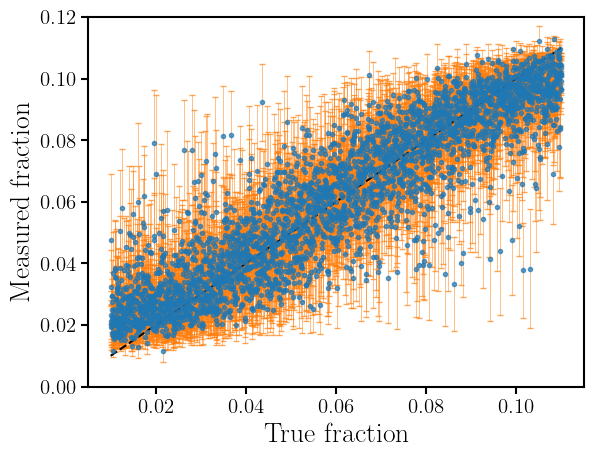

MSE error: 0.0001487612
2
Reduced chi2: 1.3262410121681416


In [10]:
j = 2**15
Pks, labels, lenk = NINf.load_Pkf("outbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, n_load=j)
print(lenk)
max_corr = labels[:,:-1].max(axis=0)
min_corr = labels[:,:-1].min(axis=0)

Pks, labels, lenk = NINf.load_Pkf("outbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, norm_c=True, n_load=j)

##Priors
Pk_paths = pd.read_csv("outbox_all-fs-RSD-BSQ.csv")

sP = {'sigma_8': 0.0060, 'Omega_m': 0.0056, 'h': 0.0042, 'n_s': 0.0038, 'Omega_b': 0.0008} #from Table 2 in Planck 2018 (1807.06209)
priors = ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
len_priors = len(priors)
np.random.seed(j) #for reproducibility of the MSE and plots
r = np.random.normal(size=(len(Pks), len_priors))
cosmo_p = np.zeros((len(Pks), len_priors))

for i, prior in enumerate(priors):
    if len_priors == 1:
        cosmo_p = np.reshape(Pk_paths[prior],((len(Pks),1))) + r * sP[prior] * 1. #31 times Planck
    else:
        cosmo_p[:,i] = Pk_paths[prior][:j] + r[:,i] * sP[prior] * 1. #1 times Planck

#print(cosmo_p)

Pks = np.hstack((Pks, cosmo_p)) #I also normalize cosmo_p between 0 and 1
#Loading max min

n = f'NoInterNet-Logloss-P0-P0-allprior1P-{j:d}-moments' if j != 2**15 else 'NoInterNet-Logloss-P0-P0-allprior1P-BSQ-moments'

min_Pks, max_Pks = np.loadtxt("../trained-model/BSQ/RSD/outbox/" + n + "/maxmin.dat", unpack=True)
Pks = NINf.maxmin_corr(Pks, max_Pks, min_Pks)
norm = np.ones(len(Pks))

fs = labels[:,-1]

_, ind = np.unique(fs, return_index=True)
f_u = np.array([fs[indx] for indx in sorted(ind)]) #non ordered unique interloper fraction array

n_train = int(len(f_u)*0.75)
n_val = int(len(f_u)*0.9)

fs_test = (f_u[n_val:])

sel_test = np.array([], dtype=int)

for f in fs_test: sel_test= np.append(sel_test, np.where(fs == f)[0])

Pks_test = Pks[sel_test]
labels_test = labels[sel_test]

norm_test = np.array(norm[sel_test, np.newaxis])

test = NIN.PkDataset(Pks_test, labels_test, norm_test)

test_batch = 10
test_dataloader = DataLoader(test, batch_size=test_batch, shuffle=True)
model = NINf.NoInterNet_fraction_compress_inference(lenk+5, 64, lenk, 64, n_min=16).to(device)
NIN.resume(model, "../trained-model/BSQ/RSD/outbox/" + n + "/best_model-64.pth", device)
print(j)
plot_fraction(test, model, lenk=lenk, device=device, norm_fs=True, save=None)
chi2(test, model, lenk=lenk, device=device, norm_fs=True, thresh=1e-3)

/tmp/ipykernel_51685/3810797402.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.,0.6)


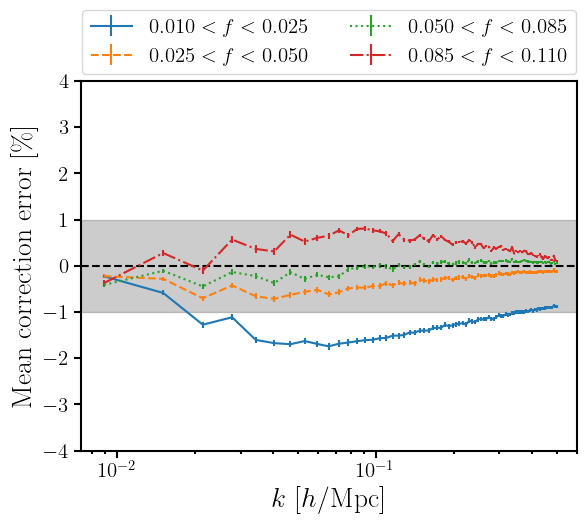

In [11]:
ks = np.loadtxt('ks-gris.dat')

p_mean1, y_mean1, std_mean1, m1, sm1, N1 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.001, 0.025, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean2, y_mean2, std_mean2, m2, sm2, N2 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.025, 0.050, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean3, y_mean3, std_mean3, m3, sm3, N3 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.050, 0.085, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean4, y_mean4, std_mean4, m4, sm4, N4 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.085, 0.110, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)

sel = (ks> 0.) & (ks < 0.5)
k_plot = ks[sel]

plt.errorbar(k_plot, m1[:lenk] * 100., yerr=sm1[:lenk]*100., label='$0.010 < f < 0.025$', linestyle='solid')
plt.errorbar(k_plot, m2[:lenk] * 100., yerr=sm2[:lenk]*100., label='$0.025 < f < 0.050$', linestyle='dashed')
plt.errorbar(k_plot, m3[:lenk] * 100., yerr=sm3[:lenk]*100., label='$0.050 < f < 0.085$', linestyle='dotted')
plt.errorbar(k_plot, m4[:lenk] * 100., yerr=sm4[:lenk]*100., label='$0.085 < f < 0.110$', linestyle='dashdot')

plt.axhline(0, color='k', linestyle='dashed')
plt.xscale('log')
plt.xlabel('$k$ [$h$/Mpc]')
plt.ylim(-4.,4.)
plt.xlim(0.,0.6)
plt.ylabel('''Mean correction error [$\\%$]''')

plt.fill_between([0., .6], -1, 1, alpha=.2, color='k')

plt.legend(ncols=2, loc='lower center', bbox_to_anchor=(0.5,0.99))
#plt.tight_layout()
plt.show()

### 3 Planck prior

I plot the fraction scatter for all the training set $N$ and the correction only for the largest one

In [12]:
for j in N:
    Pks, labels, lenk = NINf.load_Pkf("outbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, n_load=j)
    print(lenk)
    max_corr = labels[:,:-1].max(axis=0)
    min_corr = labels[:,:-1].min(axis=0)
    
    Pks, labels, lenk = NINf.load_Pkf("outbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, norm_c=True, n_load=j)
    
    ##Priors
    Pk_paths = pd.read_csv("outbox_all-fs-RSD-BSQ.csv")
    
    sP = {'sigma_8': 0.0060, 'Omega_m': 0.0056, 'h': 0.0042, 'n_s': 0.0038, 'Omega_b': 0.0008} #from Table 2 in Planck 2018 (1807.06209)
    priors = ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
    len_priors = len(priors)
    np.random.seed(j) #for reproducibility of the MSE and plots
    r = np.random.normal(size=(len(Pks), len_priors))
    cosmo_p = np.zeros((len(Pks), len_priors))
    
    for i, prior in enumerate(priors):
        if len_priors == 1:
            cosmo_p = np.reshape(Pk_paths[prior],((len(Pks),1))) + r * sP[prior] * 3. #3 times Planck
        else:
            cosmo_p[:,i] = Pk_paths[prior][:j] + r[:,i] * sP[prior] * 3. #3 times Planck
    
    #print(cosmo_p)
    
    Pks = np.hstack((Pks, cosmo_p)) #I also normalize cosmo_p between 0 and 1
    #Loading max min
    
    n = f'NoInterNet-Logloss-P0-P0-allprior3P-{j:d}-moments' if j != 2**15 else 'NoInterNet-Logloss-P0-P0-allprior3P-BSQ-moments'
    
    min_Pks, max_Pks = np.loadtxt("../trained-model/BSQ/RSD/outbox/" + n + "/maxmin.dat", unpack=True)
    Pks = NINf.maxmin_corr(Pks, max_Pks, min_Pks)
    norm = np.ones(len(Pks))
    
    fs = labels[:,-1]
    
    _, ind = np.unique(fs, return_index=True)
    f_u = np.array([fs[indx] for indx in sorted(ind)]) #non ordered unique interloper fraction array
    
    n_train = int(len(f_u)*0.75)
    n_val = int(len(f_u)*0.9)
    
    fs_test = (f_u[n_val:])
    
    sel_test = np.array([], dtype=int)
    
    for f in fs_test: sel_test= np.append(sel_test, np.where(fs == f)[0])
    
    Pks_test = Pks[sel_test]
    labels_test = labels[sel_test]
    
    norm_test = np.array(norm[sel_test, np.newaxis])
    
    test = NIN.PkDataset(Pks_test, labels_test, norm_test)
    
    test_batch = 10
    test_dataloader = DataLoader(test, batch_size=test_batch, shuffle=True)

    model = NINf.NoInterNet_fraction_compress_inference(lenk+5, 64, lenk, 64, n_min=16).to(device)
    NIN.resume(model, "../trained-model/BSQ/RSD/outbox/" + n + "/best_model-64.pth", device)

    print(j)
    #plot_fraction(test, model, lenk=lenk, device=device, norm_fs=True, save=None)
    chi2(test, model, lenk=lenk, device=device, norm_fs=True, thresh=1e-3)
    

79
1 64 32
2 32 16
3 16 32
4 32 64
512
0
Reduced chi2: 1.2814240088829627


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
1024
0
Reduced chi2: 2.6618907150712987


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
2048
0
Reduced chi2: 1.200390252834413


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
4096
0
Reduced chi2: 1.6804517792492377


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
8192
0
Reduced chi2: 1.3410451005144817


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
16384
1
Reduced chi2: 1.2948710806417785


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
32768
0
Reduced chi2: 0.9840295376630683


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

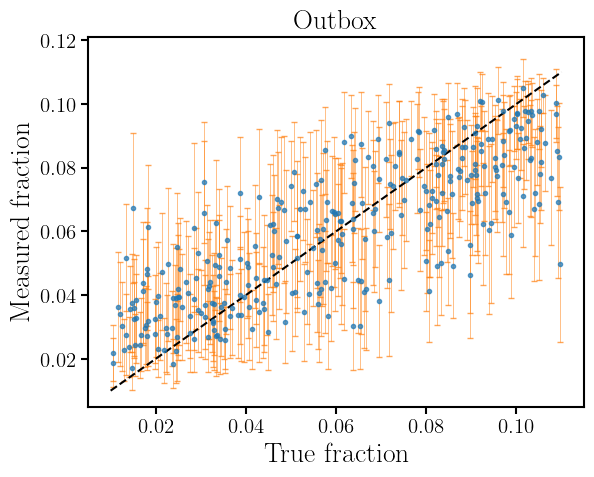

MSE error: 0.00029502902


In [13]:
plot_fraction(test, model, lenk=lenk, device=device, norm_fs=True, equal=False, limits=[0.005, 0.121], title='Outbox', step=10) #, save='../figures/fraction-scatter-outbox-BSQ-P0-P0.png'

/tmp/ipykernel_51685/158986796.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.,0.6)


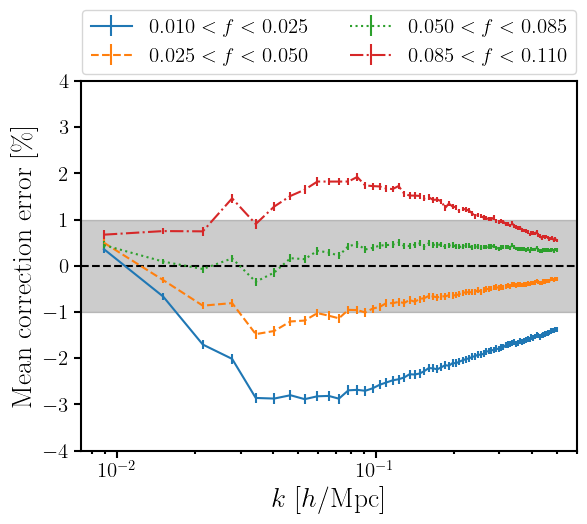

In [14]:
ks = np.loadtxt('ks-gris.dat')

p_mean1, y_mean1, std_mean1, m1, sm1, N1 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.001, 0.025, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean2, y_mean2, std_mean2, m2, sm2, N2 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.025, 0.050, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean3, y_mean3, std_mean3, m3, sm3, N3 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.050, 0.085, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean4, y_mean4, std_mean4, m4, sm4, N4 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.085, 0.110, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)

sel = (ks> 0.) & (ks < 0.5)
k_plot = ks[sel]

plt.errorbar(k_plot, m1[:lenk] * 100., yerr=sm1[:lenk]*100., label='$0.010 < f < 0.025$', linestyle='solid')
plt.errorbar(k_plot, m2[:lenk] * 100., yerr=sm2[:lenk]*100., label='$0.025 < f < 0.050$', linestyle='dashed')
plt.errorbar(k_plot, m3[:lenk] * 100., yerr=sm3[:lenk]*100., label='$0.050 < f < 0.085$', linestyle='dotted')
plt.errorbar(k_plot, m4[:lenk] * 100., yerr=sm4[:lenk]*100., label='$0.085 < f < 0.110$', linestyle='dashdot')

plt.axhline(0, color='k', linestyle='dashed')
plt.xscale('log')
plt.xlabel('$k$ [$h$/Mpc]')
plt.ylim(-4.,4.)
plt.xlim(0.,0.6)
plt.ylabel('''Mean correction error [$\\%$]''')

plt.fill_between([0., .6], -1, 1, alpha=.2, color='k')

plt.legend(ncols=2, loc='lower center', bbox_to_anchor=(0.5,0.99))
#plt.tight_layout()
#plt.savefig('../figures/MCE-outbox-BSQ-P0-P0-3P.pdf', bbox_inches='tight')
plt.show()

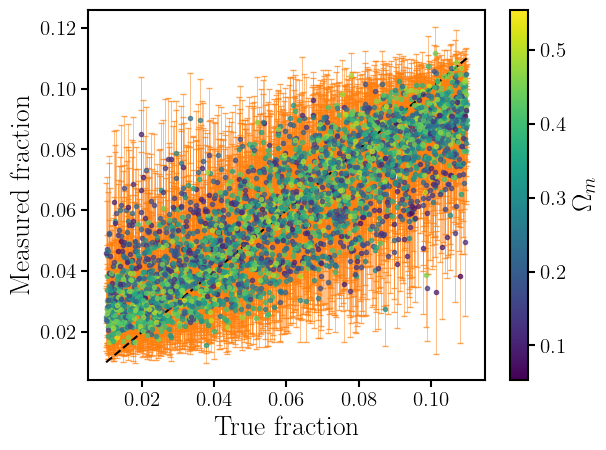

MSE error: 0.0002762753


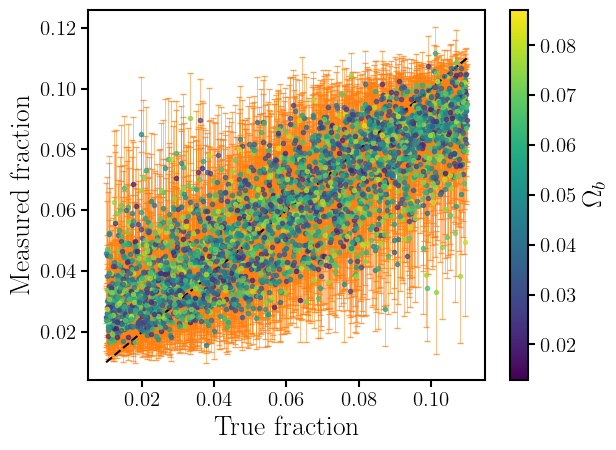

MSE error: 0.0002762753


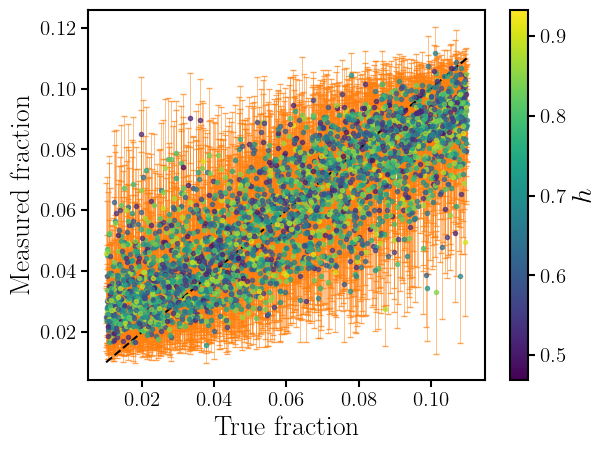

MSE error: 0.0002762753


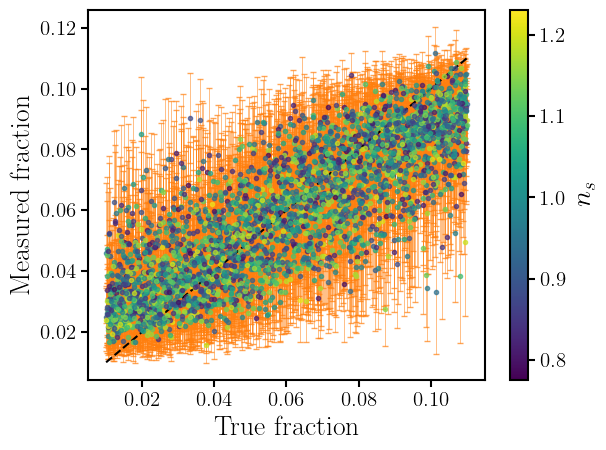

MSE error: 0.0002762753


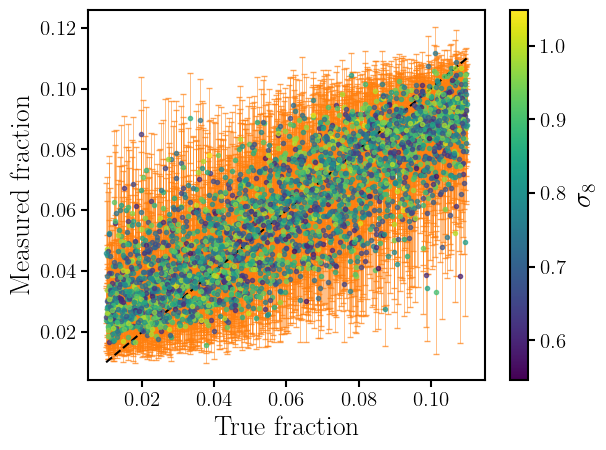

MSE error: 0.0002762753


In [15]:
plot_fraction_cosmocolor(test, model, lenk=lenk, device=device, cosmo_ind=-5, cosmo_name='$\\Omega_m$', norm_fs=True, save=None, max_corr=max_Pks, min_corr=min_Pks)
plot_fraction_cosmocolor(test, model, lenk=lenk, device=device, cosmo_ind=-4, cosmo_name='$\\Omega_b$', norm_fs=True, save=None, max_corr=max_Pks, min_corr=min_Pks)
plot_fraction_cosmocolor(test, model, lenk=lenk, device=device, cosmo_ind=-3, cosmo_name='$h$', norm_fs=True, save=None, max_corr=max_Pks, min_corr=min_Pks)
plot_fraction_cosmocolor(test, model, lenk=lenk, device=device, cosmo_ind=-2, cosmo_name='$n_s$', norm_fs=True, save=None, max_corr=max_Pks, min_corr=min_Pks)
plot_fraction_cosmocolor(test, model, lenk=lenk, device=device, cosmo_ind=-1, cosmo_name='$\\sigma_8$', norm_fs=True, save=None, max_corr=max_Pks, min_corr=min_Pks)


### 5 Planck prior

I plot the fraction scatter for all the training set $N$ and the correction only for the largest one

In [16]:
for j in N:
    ks, labels, lenk = NINf.load_Pkf("outbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, n_load=j)
    print(lenk)
    max_corr = labels[:,:-1].max(axis=0)
    min_corr = labels[:,:-1].min(axis=0)
    
    Pks, labels, lenk = NINf.load_Pkf("outbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, norm_c=True, n_load=j)
    
    ##Priors
    Pk_paths = pd.read_csv("outbox_all-fs-RSD-BSQ.csv")
    
    sP = {'sigma_8': 0.0060, 'Omega_m': 0.0056, 'h': 0.0042, 'n_s': 0.0038, 'Omega_b': 0.0008} #from Table 2 in Planck 2018 (1807.06209)
    priors = ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
    len_priors = len(priors)
    np.random.seed(j) #for reproducibility of the MSE and plots
    r = np.random.normal(size=(len(Pks), len_priors))
    cosmo_p = np.zeros((len(Pks), len_priors))
    
    for i, prior in enumerate(priors):
        if len_priors == 1:
            cosmo_p = np.reshape(Pk_paths[prior],((len(Pks),1))) + r * sP[prior] * 5. #5 times Planck
        else:
            cosmo_p[:,i] = Pk_paths[prior][:j] + r[:,i] * sP[prior] * 5. #5 times Planck
    
    #print(cosmo_p)
    
    Pks = np.hstack((Pks, cosmo_p)) #I also normalize cosmo_p between 0 and 1
    #Loading max min
    
    n = f'NoInterNet-Logloss-P0-P0-allprior5P-{j:d}-moments' if j != 2**15 else 'NoInterNet-Logloss-P0-P0-allprior5P-BSQ-moments'
    
    min_Pks, max_Pks = np.loadtxt("../trained-model/BSQ/RSD/outbox/" + n + "/maxmin.dat", unpack=True)
    Pks = NINf.maxmin_corr(Pks, max_Pks, min_Pks)
    norm = np.ones(len(Pks))
    
    fs = labels[:,-1]
    
    _, ind = np.unique(fs, return_index=True)
    f_u = np.array([fs[indx] for indx in sorted(ind)]) #non ordered unique interloper fraction array
    
    n_train = int(len(f_u)*0.75)
    n_val = int(len(f_u)*0.9)
    
    fs_test = (f_u[n_val:])
    
    sel_test = np.array([], dtype=int)
    
    for f in fs_test: sel_test= np.append(sel_test, np.where(fs == f)[0])
    
    Pks_test = Pks[sel_test]
    labels_test = labels[sel_test]
    
    norm_test = np.array(norm[sel_test, np.newaxis])
    
    test = NIN.PkDataset(Pks_test, labels_test, norm_test)
    
    test_batch = 10
    test_dataloader = DataLoader(test, batch_size=test_batch, shuffle=True)

    model = NINf.NoInterNet_fraction_compress_inference(lenk+5, 64, lenk, 64, n_min=16).to(device)
    NIN.resume(model, "../trained-model/BSQ/RSD/outbox/" + n + "/best_model-64.pth", device)

    print(j)
    #plot_fraction(test, model, lenk=lenk, device=device, norm_fs=True, save=None)
    chi2(test, model, lenk=lenk, device=device, norm_fs=True, thresh=1e-3)

79
1 64 32
2 32 16
3 16 32
4 32 64
512
0
Reduced chi2: 1.0317122386052058


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
1024
0
Reduced chi2: 1.8058330943283525


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
2048
0
Reduced chi2: 1.0466269888528963


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
4096
0
Reduced chi2: 1.3966225228658538


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
8192
0
Reduced chi2: 1.2305690114091081


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
16384
0
Reduced chi2: 1.0813854466566886


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
32768
0
Reduced chi2: 1.1077447634555233


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

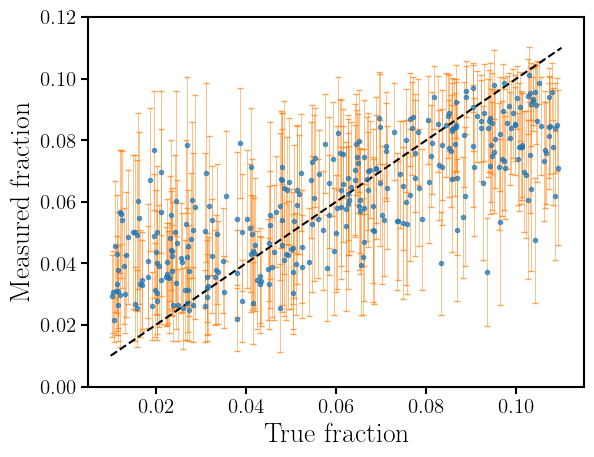

MSE error: 0.00036248623


In [17]:
plot_fraction(test, model, lenk=lenk, device=device, norm_fs=True, step=10)#, save='../figures/fraction-scatter-outbox-P0-5P.png')

/tmp/ipykernel_51685/3810797402.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.,0.6)


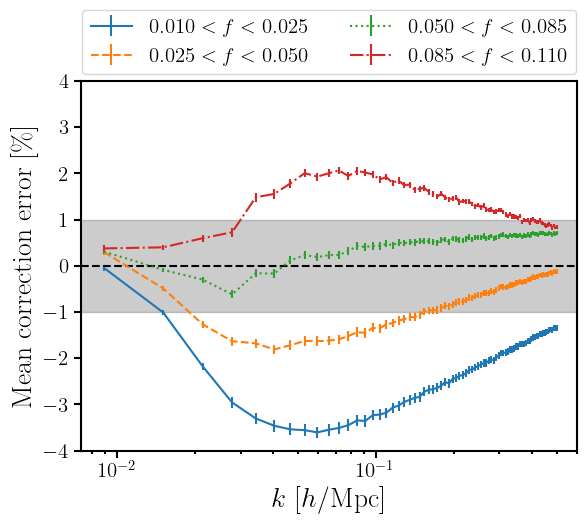

In [18]:
ks = np.loadtxt('ks-gris.dat')

p_mean1, y_mean1, std_mean1, m1, sm1, N1 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.001, 0.025, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean2, y_mean2, std_mean2, m2, sm2, N2 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.025, 0.050, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean3, y_mean3, std_mean3, m3, sm3, N3 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.050, 0.085, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean4, y_mean4, std_mean4, m4, sm4, N4 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.085, 0.110, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)

sel = (ks> 0.) & (ks < 0.5)
k_plot = ks[sel]

plt.errorbar(k_plot, m1[:lenk] * 100., yerr=sm1[:lenk]*100., label='$0.010 < f < 0.025$', linestyle='solid')
plt.errorbar(k_plot, m2[:lenk] * 100., yerr=sm2[:lenk]*100., label='$0.025 < f < 0.050$', linestyle='dashed')
plt.errorbar(k_plot, m3[:lenk] * 100., yerr=sm3[:lenk]*100., label='$0.050 < f < 0.085$', linestyle='dotted')
plt.errorbar(k_plot, m4[:lenk] * 100., yerr=sm4[:lenk]*100., label='$0.085 < f < 0.110$', linestyle='dashdot')

plt.axhline(0, color='k', linestyle='dashed')
plt.xscale('log')
plt.xlabel('$k$ [$h$/Mpc]')
plt.ylim(-4.,4.)
plt.xlim(0.,0.6)
plt.ylabel('''Mean correction error [$\\%$]''')

plt.fill_between([0., .6], -1, 1, alpha=.2, color='k')

plt.legend(ncols=2, loc='lower center', bbox_to_anchor=(0.5,0.99))
#plt.tight_layout()
plt.show()

## P0B0 -> P0

#### 0 Planck prior 

79 294
1 64 32
2 32 16
3 16 32
4 32 64
32768


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

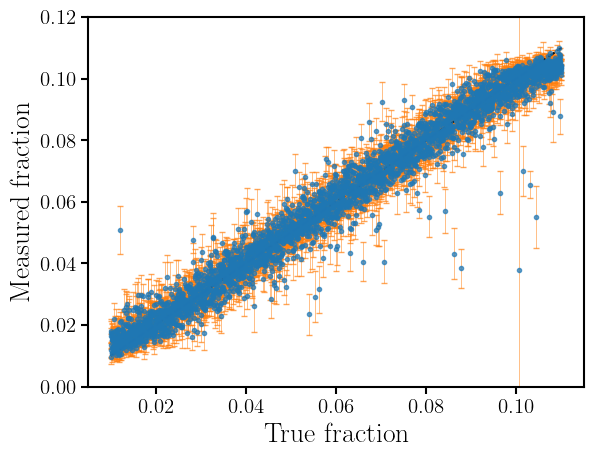

MSE error: 2.6164325e-05
9
Reduced chi2: 1.5844915795697283


In [19]:
j = 2**15
PBs, labels, lenP, lenB = NINf.load_PBf("outbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, n_load=j)
print(lenP, lenB)
max_corr = labels[:,:-1].max(axis=0)
min_corr = labels[:,:-1].min(axis=0)

PBs, labels, lenP, lenB = NINf.load_PBf("outbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, norm_c=True, n_load=j)

##Priors
Pk_paths = pd.read_csv("outbox_all-fs-RSD-BSQ.csv")

sP = {'sigma_8': 0.0060, 'Omega_m': 0.0056, 'h': 0.0042, 'n_s': 0.0038, 'Omega_b': 0.0008} #from Table 2 in Planck 2018 (1807.06209)
priors = ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
len_priors = len(priors)
np.random.seed(j) #for reproducibility of the MSE and plots
r = np.random.normal(size=(len(PBs), len_priors))
cosmo_p = np.zeros((len(PBs), len_priors))

for i, prior in enumerate(priors):
    if len_priors == 1:
        cosmo_p = np.reshape(Pk_paths[prior],((len(PBs),1))) + r * sP[prior] * 0. #0 times Planck
    else:
        cosmo_p[:,i] = Pk_paths[prior][:j] + r[:,i] * sP[prior] * 0. #0 times Planck

#print(cosmo_p)

PBs = np.hstack((PBs, cosmo_p)) #I also normalize cosmo_p between 0 and 1
#Loading max min

n = f'NoInterNet-Logloss-P0B0-P0-allprior0P-{j:d}-moments' if j != 2**15 else 'NoInterNet-Logloss-P0B0-P0-allprior0P-BSQ-moments'
min_PBs, max_PBs = np.loadtxt("../trained-model/BSQ/RSD/outbox/" + n + "/maxmin.dat", unpack=True)
PBs = NINf.maxmin_corr(PBs, max_PBs, min_PBs)
norm = np.ones(len(PBs))

fs = labels[:,-1]

_, ind = np.unique(fs, return_index=True)
f_u = np.array([fs[indx] for indx in sorted(ind)]) #non ordered unique interloper fraction array

n_train = int(len(f_u)*0.75)
n_val = int(len(f_u)*0.9)

fs_test = (f_u[n_val:])

sel_test = np.array([], dtype=int)

for f in fs_test: sel_test= np.append(sel_test, np.where(fs == f)[0])

PBs_test = PBs[sel_test]
labels_test = labels[sel_test]

norm_test = np.array(norm[sel_test, np.newaxis])
    
test = NIN.PkDataset(PBs_test, labels_test, norm_test)

test_batch = 10
test_dataloader = DataLoader(test, batch_size=test_batch, shuffle=True)
model = NINf.NoInterNet_fraction_compress_inference(lenP+lenB+5, 64, lenP, 64, n_min=16).to(device)
NIN.resume(model, "../trained-model/BSQ/RSD/outbox/" + n + "/best_model-64.pth", device)
print(j)
plot_fraction(test, model, lenk=lenP, device=device, norm_fs=True, save=None)
chi2(test, model, lenk=lenk, device=device, norm_fs=True, thresh=1e-3)

/tmp/ipykernel_51685/3810797402.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.,0.6)


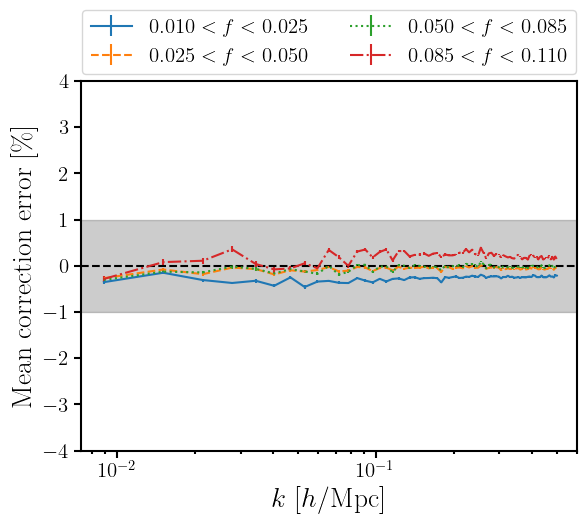

In [20]:
ks = np.loadtxt('ks-gris.dat')

p_mean1, y_mean1, std_mean1, m1, sm1, N1 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.001, 0.025, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean2, y_mean2, std_mean2, m2, sm2, N2 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.025, 0.050, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean3, y_mean3, std_mean3, m3, sm3, N3 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.050, 0.085, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean4, y_mean4, std_mean4, m4, sm4, N4 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.085, 0.110, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)

sel = (ks> 0.) & (ks < 0.5)
k_plot = ks[sel]

plt.errorbar(k_plot, m1[:lenk] * 100., yerr=sm1[:lenk]*100., label='$0.010 < f < 0.025$', linestyle='solid')
plt.errorbar(k_plot, m2[:lenk] * 100., yerr=sm2[:lenk]*100., label='$0.025 < f < 0.050$', linestyle='dashed')
plt.errorbar(k_plot, m3[:lenk] * 100., yerr=sm3[:lenk]*100., label='$0.050 < f < 0.085$', linestyle='dotted')
plt.errorbar(k_plot, m4[:lenk] * 100., yerr=sm4[:lenk]*100., label='$0.085 < f < 0.110$', linestyle='dashdot')

plt.axhline(0, color='k', linestyle='dashed')
plt.xscale('log')
plt.xlabel('$k$ [$h$/Mpc]')
plt.ylim(-4.,4.)
plt.xlim(0.,0.6)
plt.ylabel('''Mean correction error [$\\%$]''')

plt.fill_between([0., .6], -1, 1, alpha=.2, color='k')

plt.legend(ncols=2, loc='lower center', bbox_to_anchor=(0.5,0.99))
#plt.tight_layout()
plt.show()

#### 1 Planck prior 

79 294
1 64 32
2 32 16
3 16 32
4 32 64
32768


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

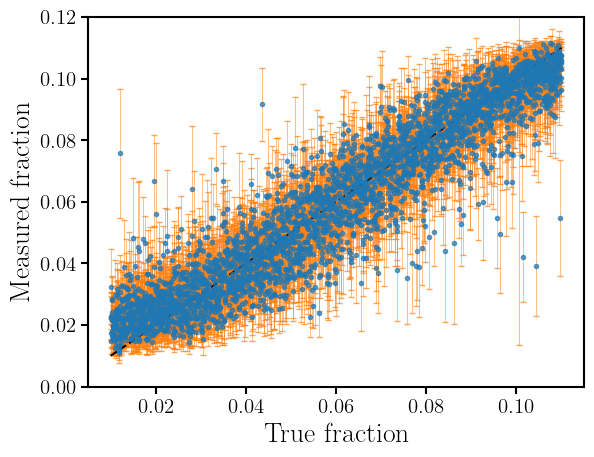

MSE error: 9.294108e-05
51
Reduced chi2: 1.2474390937309277


In [21]:
j = 2**15
PBs, labels, lenP, lenB = NINf.load_PBf("outbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, n_load=j)
print(lenP, lenB)
max_corr = labels[:,:-1].max(axis=0)
min_corr = labels[:,:-1].min(axis=0)

PBs, labels, lenP, lenB = NINf.load_PBf("outbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, norm_c=True, n_load=j)

##Priors
Pk_paths = pd.read_csv("outbox_all-fs-RSD-BSQ.csv")

sP = {'sigma_8': 0.0060, 'Omega_m': 0.0056, 'h': 0.0042, 'n_s': 0.0038, 'Omega_b': 0.0008} #from Table 2 in Planck 2018 (1807.06209)
priors = ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
len_priors = len(priors)
np.random.seed(j) #for reproducibility of the MSE and plots
r = np.random.normal(size=(len(PBs), len_priors))
cosmo_p = np.zeros((len(PBs), len_priors))

for i, prior in enumerate(priors):
    if len_priors == 1:
        cosmo_p = np.reshape(Pk_paths[prior],((len(PBs),1))) + r * sP[prior] * 1. #1 times Planck
    else:
        cosmo_p[:,i] = Pk_paths[prior][:j] + r[:,i] * sP[prior] * 1. #1 times Planck

#print(cosmo_p)

PBs = np.hstack((PBs, cosmo_p)) #I also normalize cosmo_p between 0 and 1
#Loading max min

n = f'NoInterNet-Logloss-P0B0-P0-allprior1P-{j:d}-moments' if j != 2**15 else 'NoInterNet-Logloss-P0B0-P0-allprior1P-BSQ-moments'
min_PBs, max_PBs = np.loadtxt("../trained-model/BSQ/RSD/outbox/" + n + "/maxmin.dat", unpack=True)
PBs = NINf.maxmin_corr(PBs, max_PBs, min_PBs)
norm = np.ones(len(PBs))

fs = labels[:,-1]

_, ind = np.unique(fs, return_index=True)
f_u = np.array([fs[indx] for indx in sorted(ind)]) #non ordered unique interloper fraction array

n_train = int(len(f_u)*0.75)
n_val = int(len(f_u)*0.9)

fs_test = (f_u[n_val:])

sel_test = np.array([], dtype=int)

for f in fs_test: sel_test= np.append(sel_test, np.where(fs == f)[0])

PBs_test = PBs[sel_test]
labels_test = labels[sel_test]

norm_test = np.array(norm[sel_test, np.newaxis])
    
test = NIN.PkDataset(PBs_test, labels_test, norm_test)

test_batch = 10
test_dataloader = DataLoader(test, batch_size=test_batch, shuffle=True)
model = NINf.NoInterNet_fraction_compress_inference(lenP+lenB+5, 64, lenP, 64, n_min=16).to(device)
NIN.resume(model, "../trained-model/BSQ/RSD/outbox/" + n + "/best_model-64.pth", device)
print(j)
plot_fraction(test, model, lenk=lenP, device=device, norm_fs=True, save=None)
chi2(test, model, lenk=lenk, device=device, norm_fs=True, thresh=1e-3)

/tmp/ipykernel_51685/3810797402.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.,0.6)


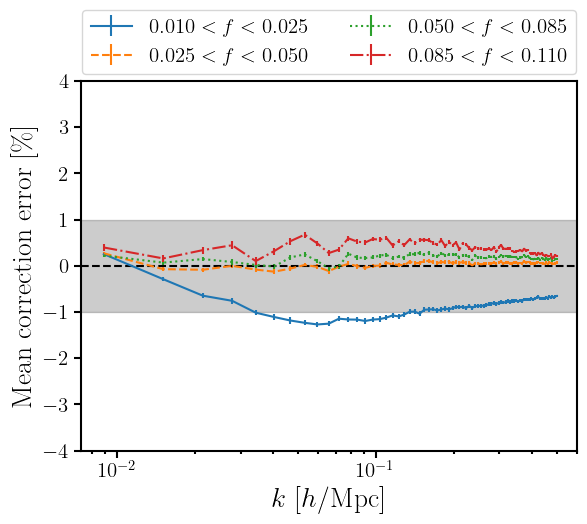

In [22]:
ks = np.loadtxt('ks-gris.dat')

p_mean1, y_mean1, std_mean1, m1, sm1, N1 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.001, 0.025, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean2, y_mean2, std_mean2, m2, sm2, N2 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.025, 0.050, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean3, y_mean3, std_mean3, m3, sm3, N3 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.050, 0.085, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean4, y_mean4, std_mean4, m4, sm4, N4 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.085, 0.110, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)

sel = (ks> 0.) & (ks < 0.5)
k_plot = ks[sel]

plt.errorbar(k_plot, m1[:lenk] * 100., yerr=sm1[:lenk]*100., label='$0.010 < f < 0.025$', linestyle='solid')
plt.errorbar(k_plot, m2[:lenk] * 100., yerr=sm2[:lenk]*100., label='$0.025 < f < 0.050$', linestyle='dashed')
plt.errorbar(k_plot, m3[:lenk] * 100., yerr=sm3[:lenk]*100., label='$0.050 < f < 0.085$', linestyle='dotted')
plt.errorbar(k_plot, m4[:lenk] * 100., yerr=sm4[:lenk]*100., label='$0.085 < f < 0.110$', linestyle='dashdot')

plt.axhline(0, color='k', linestyle='dashed')
plt.xscale('log')
plt.xlabel('$k$ [$h$/Mpc]')
plt.ylim(-4.,4.)
plt.xlim(0.,0.6)
plt.ylabel('''Mean correction error [$\\%$]''')

plt.fill_between([0., .6], -1, 1, alpha=.2, color='k')

plt.legend(ncols=2, loc='lower center', bbox_to_anchor=(0.5,0.99))
#plt.tight_layout()
plt.show()

#### 3 Planck prior

I plot the fraction scatter for all the training set $N$ and the correction only for the largest one

In [23]:
for j in N:
    PBs, labels, lenP, lenB = NINf.load_PBf("outbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, n_load=j)
    print(lenP, lenB)
    max_corr = labels[:,:-1].max(axis=0)
    min_corr = labels[:,:-1].min(axis=0)
    
    PBs, labels, lenP, lenB = NINf.load_PBf("outbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, norm_c=True, n_load=j)
    
    ##Priors
    Pk_paths = pd.read_csv("outbox_all-fs-RSD-BSQ.csv")
    
    sP = {'sigma_8': 0.0060, 'Omega_m': 0.0056, 'h': 0.0042, 'n_s': 0.0038, 'Omega_b': 0.0008} #from Table 2 in Planck 2018 (1807.06209)
    priors = ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
    len_priors = len(priors)
    np.random.seed(j) #for reproducibility of the MSE and plots
    r = np.random.normal(size=(len(PBs), len_priors))
    cosmo_p = np.zeros((len(PBs), len_priors))
    
    for i, prior in enumerate(priors):
        if len_priors == 1:
            cosmo_p = np.reshape(Pk_paths[prior],((len(PBs),1))) + r * sP[prior] * 3. #3 times Planck
        else:
            cosmo_p[:,i] = Pk_paths[prior][:j] + r[:,i] * sP[prior] * 3. #3 times Planck
    
    #print(cosmo_p)
    
    PBs = np.hstack((PBs, cosmo_p)) #I also normalize cosmo_p between 0 and 1
    #Loading max min
    
    n = f'NoInterNet-Logloss-P0B0-P0-allprior3P-{j:d}-moments' if j != 2**15 else 'NoInterNet-Logloss-P0B0-P0-allprior3P-BSQ-moments'

    min_PBs, max_PBs = np.loadtxt("../trained-model/BSQ/RSD/outbox/" + n + "/maxmin.dat", unpack=True)
    PBs = NINf.maxmin_corr(PBs, max_PBs, min_PBs)
    norm = np.ones(len(PBs))
    
    fs = labels[:,-1]
    
    _, ind = np.unique(fs, return_index=True)
    f_u = np.array([fs[indx] for indx in sorted(ind)]) #non ordered unique interloper fraction array
    
    n_train = int(len(f_u)*0.75)
    n_val = int(len(f_u)*0.9)
    
    fs_test = (f_u[n_val:])
    
    sel_test = np.array([], dtype=int)
    
    for f in fs_test: sel_test= np.append(sel_test, np.where(fs == f)[0])
    
    PBs_test = PBs[sel_test]
    labels_test = labels[sel_test]
    
    norm_test = np.array(norm[sel_test, np.newaxis])
    
    test = NIN.PkDataset(PBs_test, labels_test, norm_test)
    
    test_batch = 10
    test_dataloader = DataLoader(test, batch_size=test_batch, shuffle=True)

    model = NINf.NoInterNet_fraction_compress_inference(lenP+lenB+5, 64, lenP, 64, n_min=16).to(device)
    NIN.resume(model, "../trained-model/BSQ/RSD/outbox/" + n + "/best_model-64.pth", device)

    print(j)
    #plot_fraction(test, model, lenk=lenP, device=device, norm_fs=True, save=None)
    chi2(test, model, lenk=lenP, device=device, norm_fs=True, thresh=1e-3)
    

79 294
1 64 32
2 32 16
3 16 32
4 32 64
512
1
Reduced chi2: 12.695480346679688


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
1024
0
Reduced chi2: 7.533630963668083


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
2048
0
Reduced chi2: 2.01767578125


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
4096
10
Reduced chi2: 1.3184138600419206


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
8192
2
Reduced chi2: 1.610031202362805


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
16384
43
Reduced chi2: 1.6954861839345639


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
32768


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

23
Reduced chi2: 1.1570525275595056


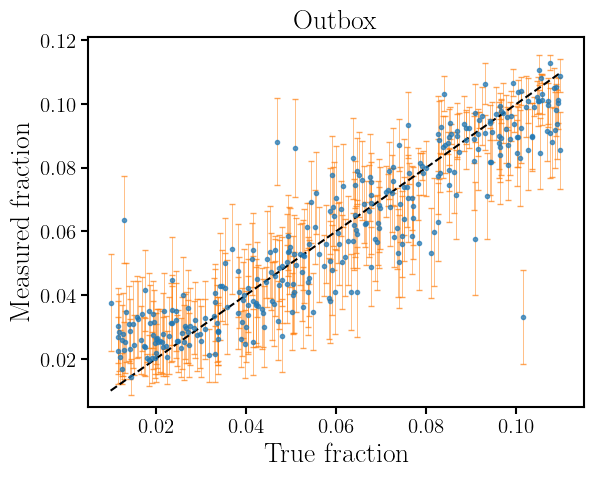

MSE error: 0.00013587142


In [24]:
plot_fraction(test, model, lenk=lenP, device=device, norm_fs=True, equal=False, limits=[0.005, 0.121], title='Outbox', step=10)#, save='../figures/fraction-scatter-outbox-BSQ-P0B0-P0.png'

/tmp/ipykernel_51685/3076022490.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.,0.6)


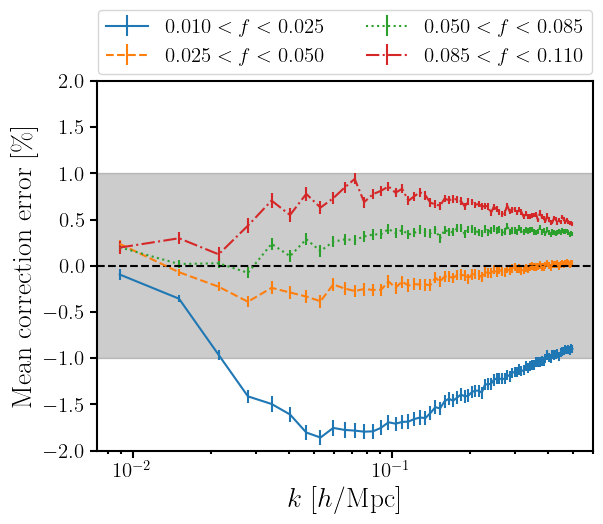

In [25]:
ks = np.loadtxt('ks-gris.dat')

p_mean1, y_mean1, std_mean1, m1, sm1, N1 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.001, 0.025, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean2, y_mean2, std_mean2, m2, sm2, N2 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.025, 0.050, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean3, y_mean3, std_mean3, m3, sm3, N3 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.050, 0.085, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean4, y_mean4, std_mean4, m4, sm4, N4 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.085, 0.110, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)

sel = (ks> 0.) & (ks < 0.5)
k_plot = ks[sel]

plt.errorbar(k_plot, m1[:lenk] * 100., yerr=sm1[:lenk]*100., label='$0.010 < f < 0.025$', linestyle='solid')
plt.errorbar(k_plot, m2[:lenk] * 100., yerr=sm2[:lenk]*100., label='$0.025 < f < 0.050$', linestyle='dashed')
plt.errorbar(k_plot, m3[:lenk] * 100., yerr=sm3[:lenk]*100., label='$0.050 < f < 0.085$', linestyle='dotted')
plt.errorbar(k_plot, m4[:lenk] * 100., yerr=sm4[:lenk]*100., label='$0.085 < f < 0.110$', linestyle='dashdot')

plt.axhline(0, color='k', linestyle='dashed')
plt.xscale('log')
plt.xlabel('$k$ [$h$/Mpc]')
plt.ylim(-2.,2.)
plt.xlim(0.,0.6)
plt.ylabel('''Mean correction error [$\\%$]''')

plt.fill_between([0., .6], -1, 1, alpha=.2, color='k')

plt.legend(ncols=2, loc='lower center', bbox_to_anchor=(0.5,0.99))
#plt.tight_layout()
#plt.savefig('../figures/MCE-outbox-BSQ-P0B0-P0-3P-yl2.pdf', bbox_inches='tight')
plt.show()

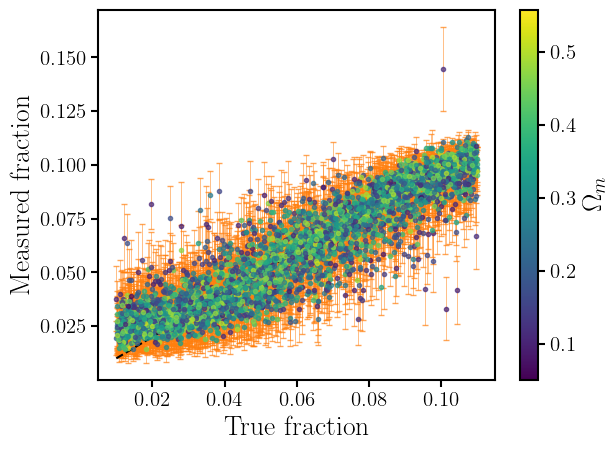

MSE error: 0.0001361745


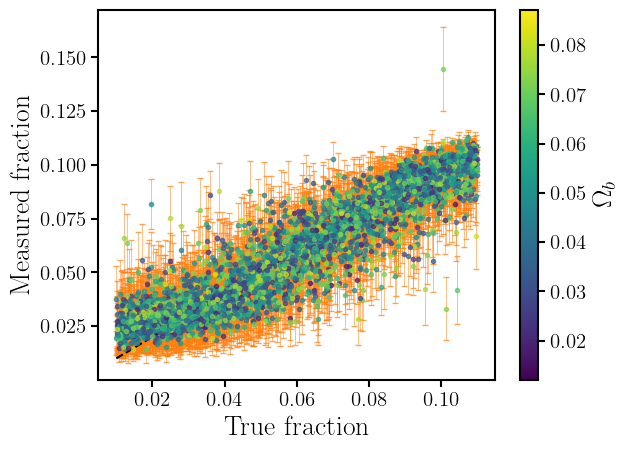

MSE error: 0.0001361745


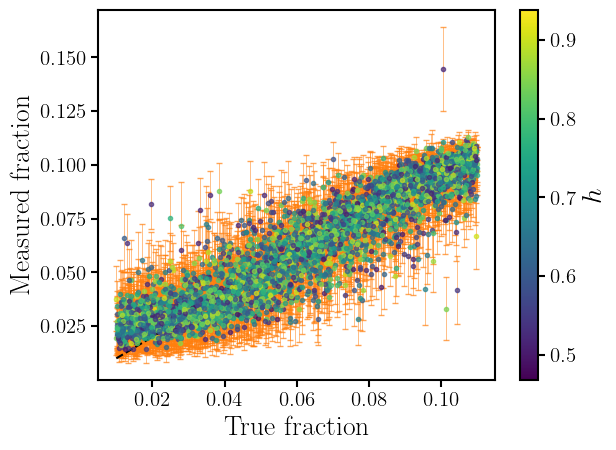

MSE error: 0.0001361745


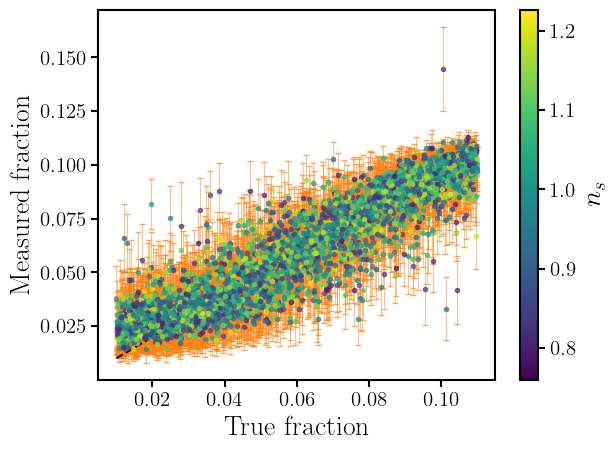

MSE error: 0.0001361745


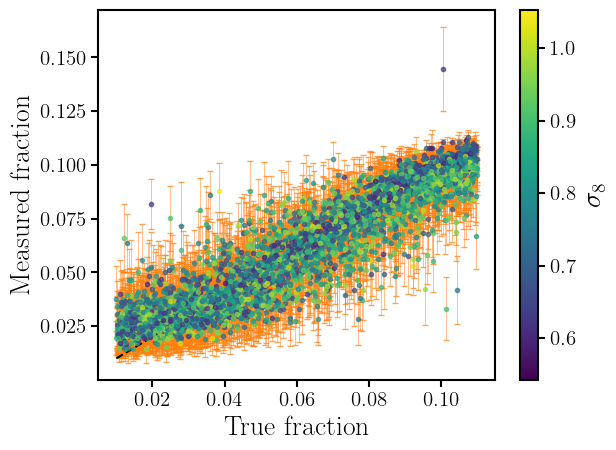

MSE error: 0.0001361745


In [26]:
plot_fraction_cosmocolor(test, model, lenk=lenk, device=device, cosmo_ind=-5, cosmo_name='$\\Omega_m$', norm_fs=True, save=None, max_corr=max_PBs, min_corr=min_PBs)
plot_fraction_cosmocolor(test, model, lenk=lenk, device=device, cosmo_ind=-4, cosmo_name='$\\Omega_b$', norm_fs=True, save=None, max_corr=max_PBs, min_corr=min_PBs)
plot_fraction_cosmocolor(test, model, lenk=lenk, device=device, cosmo_ind=-3, cosmo_name='$h$', norm_fs=True, save=None, max_corr=max_PBs, min_corr=min_PBs)
plot_fraction_cosmocolor(test, model, lenk=lenk, device=device, cosmo_ind=-2, cosmo_name='$n_s$', norm_fs=True, save=None, max_corr=max_PBs, min_corr=min_PBs)
plot_fraction_cosmocolor(test, model, lenk=lenk, device=device, cosmo_ind=-1, cosmo_name='$\\sigma_8$', norm_fs=True, save=None, max_corr=max_PBs, min_corr=min_PBs)

#### 5 Planck prior

I plot the fraction scatter for all the training set $N$ and the correction only for the largest one

In [27]:
for j in N:
    PBs, labels, lenP, lenB = NINf.load_PBf("outbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, n_load=j)
    print(lenP, lenB)
    max_corr = labels[:,:-1].max(axis=0)
    min_corr = labels[:,:-1].min(axis=0)
    
    PBs, labels, lenP, lenB = NINf.load_PBf("outbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, norm_c=True, n_load=j)
    
    ##Priors
    Pk_paths = pd.read_csv("outbox_all-fs-RSD-BSQ.csv")
    
    sP = {'sigma_8': 0.0060, 'Omega_m': 0.0056, 'h': 0.0042, 'n_s': 0.0038, 'Omega_b': 0.0008} #from Table 2 in Planck 2018 (1807.06209)
    priors = ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
    len_priors = len(priors)
    np.random.seed(j) #for reproducibility of the MSE and plots
    r = np.random.normal(size=(len(PBs), len_priors))
    cosmo_p = np.zeros((len(PBs), len_priors))
    
    for i, prior in enumerate(priors):
        if len_priors == 1:
            cosmo_p = np.reshape(Pk_paths[prior],((len(PBs),1))) + r * sP[prior] * 5. #5 times Planck
        else:
            cosmo_p[:,i] = Pk_paths[prior][:j] + r[:,i] * sP[prior] * 5. #5 times Planck
    

    PBs = np.hstack((PBs, cosmo_p)) #I also normalize cosmo_p between 0 and 1
    #Loading max min
    
    n = f'NoInterNet-Logloss-P0B0-P0-allprior5P-{j:d}-moments' if j != 2**15 else 'NoInterNet-Logloss-P0B0-P0-allprior5P-BSQ-moments'

    min_PBs, max_PBs = np.loadtxt("../trained-model/BSQ/RSD/outbox/" + n + "/maxmin.dat", unpack=True)
    PBs = NINf.maxmin_corr(PBs, max_PBs, min_PBs)
    norm = np.ones(len(PBs))
    
    fs = labels[:,-1]
    
    _, ind = np.unique(fs, return_index=True)
    f_u = np.array([fs[indx] for indx in sorted(ind)]) #non ordered unique interloper fraction array
    
    n_train = int(len(f_u)*0.75)
    n_val = int(len(f_u)*0.9)
    
    fs_test = (f_u[n_val:])
    
    sel_test = np.array([], dtype=int)
    
    for f in fs_test: sel_test= np.append(sel_test, np.where(fs == f)[0])
    
    PBs_test = PBs[sel_test]
    labels_test = labels[sel_test]
    
    norm_test = np.array(norm[sel_test, np.newaxis])
    
    test = NIN.PkDataset(PBs_test, labels_test, norm_test)
    
    test_batch = 10
    test_dataloader = DataLoader(test, batch_size=test_batch, shuffle=True)

    model = NINf.NoInterNet_fraction_compress_inference(lenP+lenB+5, 64, lenP, 64, n_min=16).to(device)
    NIN.resume(model, "../trained-model/BSQ/RSD/outbox/" + n + "/best_model-64.pth", device)

    print(j)
    #plot_fraction(test, model, lenk=lenP, device=device, norm_fs=True, save=None)
    chi2(test, model, lenk=lenk, device=device, norm_fs=True, thresh=1e-3)

79 294
1 64 32
2 32 16
3 16 32
4 32 64
512
0
Reduced chi2: 19.46278498722957


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
1024
0
Reduced chi2: 10.050835766838592


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
2048
0
Reduced chi2: 2.2112983517530487


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
4096
0
Reduced chi2: 1.5581065108136434


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
8192
6
Reduced chi2: 1.8571162526200458


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
16384
12
Reduced chi2: 1.6375530585055673


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
32768
43
Reduced chi2: 1.3919923961035245


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

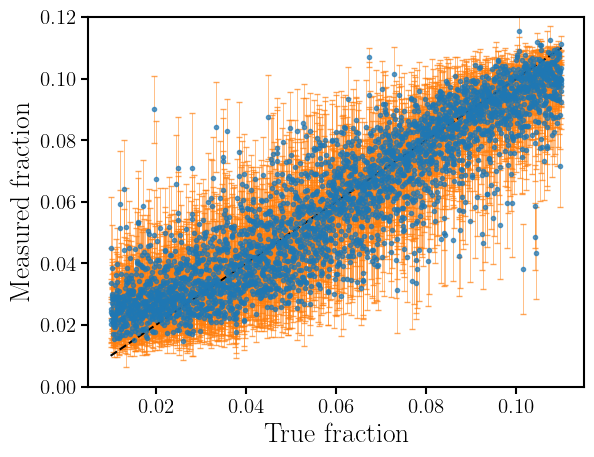

MSE error: 0.00015180283


In [28]:
plot_fraction(test, model, lenk=lenk, device=device, norm_fs=True)

/tmp/ipykernel_51685/3810797402.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.,0.6)


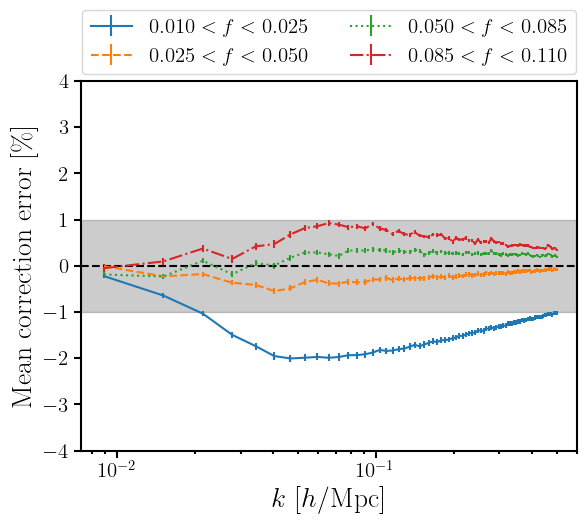

In [29]:
ks = np.loadtxt('ks-gris.dat')

p_mean1, y_mean1, std_mean1, m1, sm1, N1 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.001, 0.025, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean2, y_mean2, std_mean2, m2, sm2, N2 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.025, 0.050, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean3, y_mean3, std_mean3, m3, sm3, N3 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.050, 0.085, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean4, y_mean4, std_mean4, m4, sm4, N4 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.085, 0.110, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)

sel = (ks> 0.) & (ks < 0.5)
k_plot = ks[sel]

plt.errorbar(k_plot, m1[:lenk] * 100., yerr=sm1[:lenk]*100., label='$0.010 < f < 0.025$', linestyle='solid')
plt.errorbar(k_plot, m2[:lenk] * 100., yerr=sm2[:lenk]*100., label='$0.025 < f < 0.050$', linestyle='dashed')
plt.errorbar(k_plot, m3[:lenk] * 100., yerr=sm3[:lenk]*100., label='$0.050 < f < 0.085$', linestyle='dotted')
plt.errorbar(k_plot, m4[:lenk] * 100., yerr=sm4[:lenk]*100., label='$0.085 < f < 0.110$', linestyle='dashdot')

plt.axhline(0, color='k', linestyle='dashed')
plt.xscale('log')
plt.xlabel('$k$ [$h$/Mpc]')
plt.ylim(-4.,4.)
plt.xlim(0.,0.6)
plt.ylabel('''Mean correction error [$\\%$]''')

plt.fill_between([0., .6], -1, 1, alpha=.2, color='k')

plt.legend(ncols=2, loc='lower center', bbox_to_anchor=(0.5,0.99))
#plt.tight_layout()
plt.show()

## MSE comparison

MSE results tables: all the results use the whole BSQ

Outbox: fixed cosmology 

P0 -> P0 MSE = $8.86 \times 10^{-6}$ 

P0B0 -> P0 MSE = $6.32 \times 10^{-6}$

|Priors     |P0 |P0B0|
|:----------|:--|:---|
|Cosmo known|$5.34 \times 10^{-5}$|$2.62 \times 10^{-5}$|
|1 Planck   |$1.49 \times 10^{-4}$|$9.29 \times 10^{-5}$|
|3 Planck   |$2.77 \times 10^{-4}$|$1.36 \times 10^{-4}$|
|5 Planck   |$3.47 \times 10^{-4}$|$1.52 \times 10^{-4}$|

/tmp/ipykernel_51685/2919055413.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogy(P,P0B0,'-s',label='P0B0', linestyle='dashed')


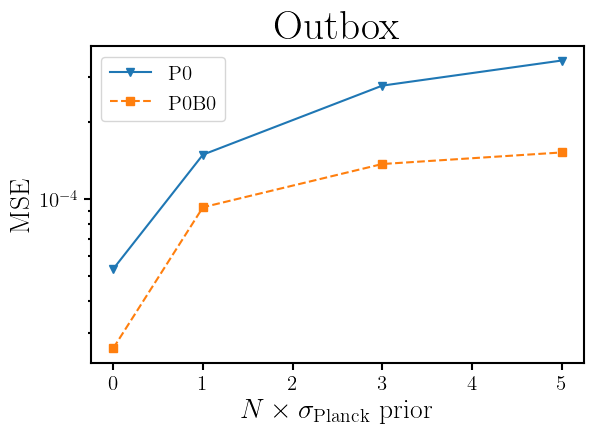

/tmp/ipykernel_51685/2919055413.py:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(P[1:], 1 - P0B0[1:]/P0B0[0], '-s', label='P0B0', linestyle='dashed')


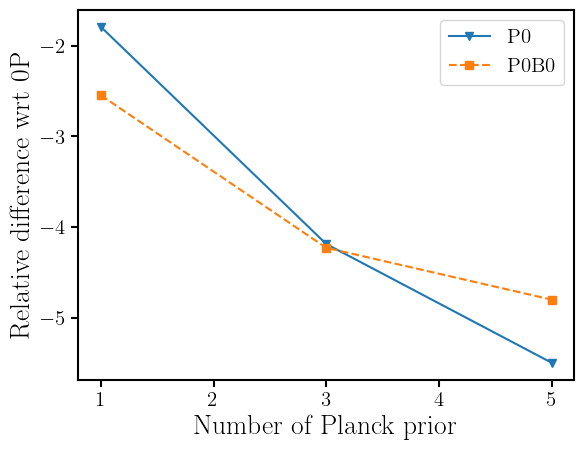

In [30]:
P = np.array([0,1,3,5])
P0 = np.array([5.34e-5, 1.49e-4, 2.77e-4, 3.47e-4])
P0B0 = np.array([2.62e-5, 9.29e-5, 1.37e-4, 1.52e-4])

plt.semilogy(P,P0,'-v',label='P0')
plt.semilogy(P,P0B0,'-s',label='P0B0', linestyle='dashed')

plt.legend()
plt.xlabel('''$N \\times \\sigma_{\\rm Planck}$ prior''')
plt.ylabel('MSE')
plt.title('Outbox')

plt.tight_layout()
#plt.savefig('../figures/MSE-NP-BSQ-outbox.pdf')

plt.show()

plt.plot(P[1:], 1 - P0[1:]/P0[0], '-v', label='P0')
plt.plot(P[1:], 1 - P0B0[1:]/P0B0[0], '-s', label='P0B0', linestyle='dashed')

plt.legend()
plt.xlabel('''Number of Planck prior''')
plt.ylabel('Relative difference wrt 0P')

plt.show()

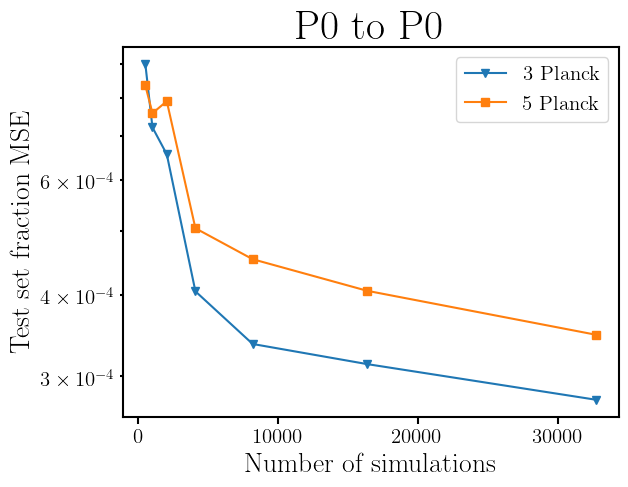

In [31]:
#N = np.array([500,1000,2000,4000,8000,10000,12000,15000,18000,21000,24000,27000,30000,2**15])


MSE_P0_3P = np.array([0.00090210757, 0.00072098774, 0.00065592246, 0.00040478093, 0.00033628137, 0.0003132645, 0.0002762753])

MSE_P0_5P = np.array([0.0008360811, 0.00075813406, 0.00079061027, 0.0005054762, 0.00045326794, 0.0004055416, 0.00034732826])

MSE_P0_0P = np.array([5.3386277e-05,])

plt.semilogy(N, MSE_P0_3P, '-v', label='3 Planck')
plt.semilogy(N, MSE_P0_5P, '-s', label='5 Planck')
#plt.semilogy([2**15,], MSE_P0_0P, '.', label='Known cosmo')


plt.xlabel('Number of simulations')
plt.ylabel('Test set fraction MSE')

plt.title('P0 to P0')
plt.legend()

plt.show()

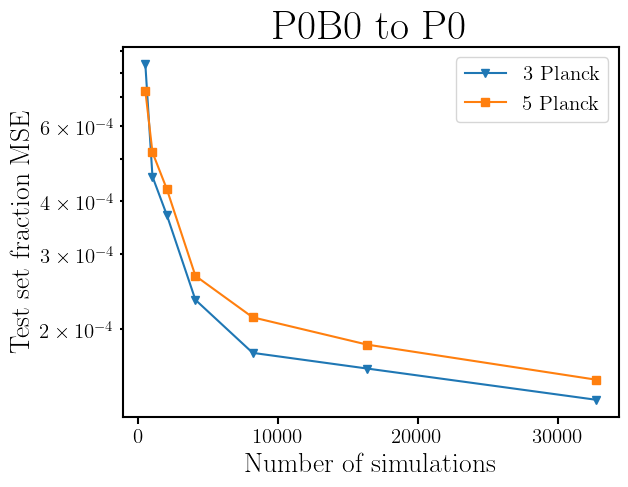

In [32]:
#N = np.array([500,1000,2000,4000,8000,10000,12000,15000,18000,21000,24000,27000,30000,2**15])

MSE_P0B0_3P = np.array([0.0008386919, 0.00045553566, 0.00037029924, 0.00023384231, 0.000175534, 0.0001612485, 0.0001361745])

MSE_P0B0_5P = np.array([0.0007254292, 0.0005193385, 0.0004260597, 0.0002662535, 0.00021276082, 0.00018353442, 0.00015180281])

plt.semilogy(N, MSE_P0B0_3P, '-v', label='3 Planck')
plt.semilogy(N, MSE_P0B0_5P, '-s', label='5 Planck')

plt.xlabel('Number of simulations')
plt.ylabel('Test set fraction MSE')

plt.title('P0B0 to P0')
plt.legend()

plt.show()

/tmp/ipykernel_51685/4220745652.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-v" (-> linestyle='-'). The keyword argument will take precedence.
  plt.loglog(N, MSE_P0B0_3P, '-v', label='$3 \\times \\sigma_{\\rm Planck}$ $P_0 + B_0$', linestyle='dashed')
/tmp/ipykernel_51685/4220745652.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  plt.loglog(N, MSE_P0B0_5P, '-s', label='$5 \\times \\sigma_{\\rm Planck}$ $P_0 + B_0$', linestyle='dashed')


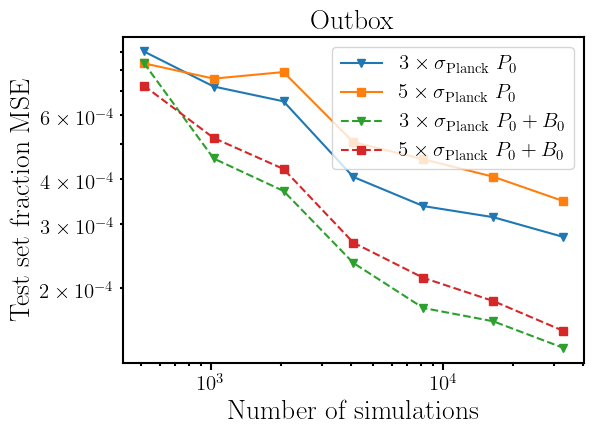

In [33]:
plt.loglog(N, MSE_P0_3P, '-v', label='$3 \\times \\sigma_{\\rm Planck}$ $P_0$')
plt.loglog(N, MSE_P0_5P, '-s', label='$5 \\times \\sigma_{\\rm Planck}$ $P_0$')

plt.loglog(N, MSE_P0B0_3P, '-v', label='$3 \\times \\sigma_{\\rm Planck}$ $P_0 + B_0$', linestyle='dashed')
plt.loglog(N, MSE_P0B0_5P, '-s', label='$5 \\times \\sigma_{\\rm Planck}$ $P_0 + B_0$', linestyle='dashed')

plt.xlabel('Number of simulations')
plt.ylabel('Test set fraction MSE')

plt.title('Outbox', size=20)
plt.legend()

plt.tight_layout()
#plt.savefig('../figures/MSE-N-BSQ-outbox.pdf')

plt.show()

# Inbox

In [34]:
N = np.array([512,1024,2048,4096,8192,16384,2**15])

## Compare Loss

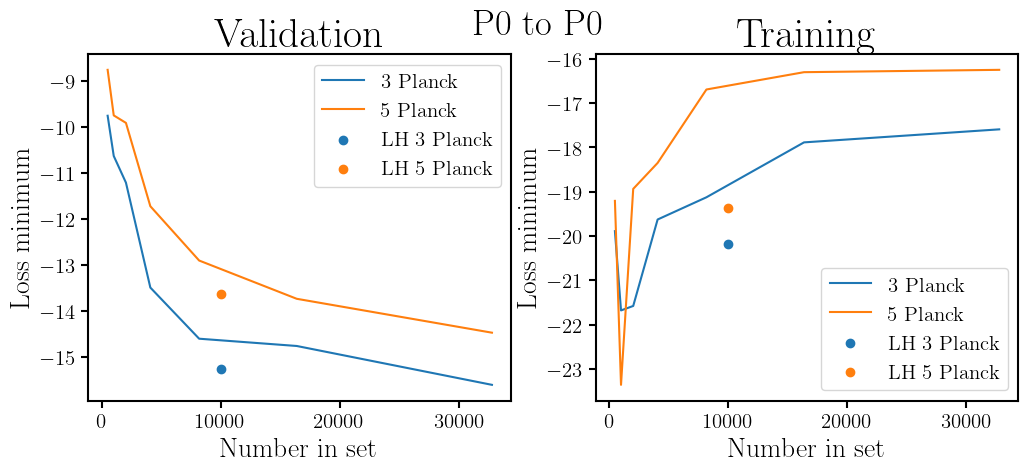

In [35]:
path = '../trained-model/BSQ/RSD/inbox/'

h_val3 = []
h_train3 = []
h_val5 = []
h_train5 = []
for i in N:
    name = path + f'NoInterNet-Logloss-P0-P0-allprior3P-BSQ-moments' if i == 2**15 else path + f'NoInterNet-Logloss-P0-P0-allprior3P-{i:d}-moments'
    name += '/history.dat'
    history_t, history_v = np.loadtxt(name, unpack=True)

    h_val3.append(np.min(history_v))
    h_train3.append(np.min(history_t))

    name = path + f'NoInterNet-Logloss-P0-P0-allprior5P-BSQ-moments' if i == 2**15 else path + f'NoInterNet-Logloss-P0-P0-allprior5P-{i:d}-moments'
    name += '/history.dat'
    history_t, history_v = np.loadtxt(name, unpack=True)

    h_val5.append(np.min(history_v))
    h_train5.append(np.min(history_t))

t, v = np.loadtxt('../trained-model/LH/RSD/inbox-90.00/NoInterNet-Logloss-P0-P0-allprior3P-allshift-moments/history.dat', unpack=True)
LH_val3 = np.min(v)
LH_train3 = np.min(t)

t, v = np.loadtxt('../trained-model/LH/RSD/inbox-90.00/NoInterNet-Logloss-P0-P0-allprior5P-allshift-moments/history.dat', unpack=True)
LH_val5 = np.min(v)
LH_train5 = np.min(t)

fig, ax = plt.subplots(1,2,figsize=(6*2,4.5))

ax[0].plot(N, h_val3, label='3 Planck')
ax[0].plot(N, h_val5, label='5 Planck')

ax[0].scatter(10000, LH_val3, label='LH 3 Planck')
ax[0].scatter(10000, LH_val5, label='LH 5 Planck')

ax[0].set_xlabel('Number in set')
ax[0].set_ylabel('Loss minimum')
ax[0].legend()
ax[0].set_title('Validation')


ax[1].plot(N, h_train3, label='3 Planck')
ax[1].plot(N, h_train5, label='5 Planck')

ax[1].scatter(10000, LH_train3, label='LH 3 Planck')
ax[1].scatter(10000, LH_train5, label='LH 5 Planck')

ax[1].set_xlabel('Number in set')
ax[1].set_ylabel('Loss minimum')
ax[1].legend()
ax[1].set_title('Training')

plt.suptitle('P0 to P0')

plt.show()

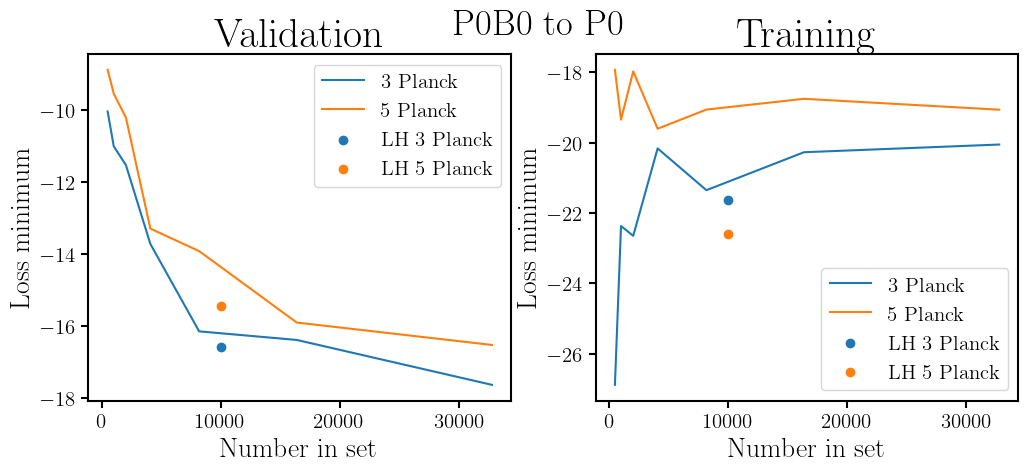

In [37]:
path = '../trained-model/BSQ/RSD/inbox/'

h_val3 = []
h_train3 = []
h_val5 = []
h_train5 = []
for i in N:
    name = path + f'NoInterNet-Logloss-P0B0-P0-allprior3P-BSQ-moments' if i == 2**15 else path + f'NoInterNet-Logloss-P0B0-P0-allprior3P-{i:d}-moments'
    name += '/history.dat'
    history_t, history_v = np.loadtxt(name, unpack=True)

    h_val3.append(np.min(history_v))
    h_train3.append(np.min(history_t))

    name = path + f'NoInterNet-Logloss-P0B0-P0-allprior5P-BSQ-moments' if i == 2**15 else path + f'NoInterNet-Logloss-P0B0-P0-allprior5P-{i:d}-moments'
    name += '/history.dat'
    history_t, history_v = np.loadtxt(name, unpack=True)

    h_val5.append(np.min(history_v))
    h_train5.append(np.min(history_t))

t, v = np.loadtxt('../trained-model/LH/RSD/inbox-90.00/NoInterNet-Logloss-P0B0-P0-allprior3P-allshift-moments/history.dat', unpack=True)
LH_val3 = np.min(v)
LH_train3 = np.min(t)

t, v = np.loadtxt('../trained-model/LH/RSD/inbox-90.00/NoInterNet-Logloss-P0B0-P0-allprior5P-allshift-moments/history.dat', unpack=True)
LH_val5 = np.min(v)
LH_train5 = np.min(t)

fig, ax = plt.subplots(1,2,figsize=(6*2,4.5))

ax[0].plot(N, h_val3, label='3 Planck')
ax[0].plot(N, h_val5, label='5 Planck')

ax[0].scatter(10000, LH_val3, label='LH 3 Planck')
ax[0].scatter(10000, LH_val5, label='LH 5 Planck')

ax[0].set_xlabel('Number in set')
ax[0].set_ylabel('Loss minimum')
ax[0].legend()
ax[0].set_title('Validation')


ax[1].plot(N, h_train3, label='3 Planck')
ax[1].plot(N, h_train5, label='5 Planck')

ax[1].scatter(10000, LH_train3, label='LH 3 Planck')
ax[1].scatter(10000, LH_train5, label='LH 5 Planck')

ax[1].set_xlabel('Number in set')
ax[1].set_ylabel('Loss minimum')
ax[1].legend()
ax[1].set_title('Training')

plt.suptitle('P0B0 to P0')

plt.show()

## P0 -> P0

### 0 Planck prior

79
1 64 32
2 32 16
3 16 32
4 32 64
32768


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

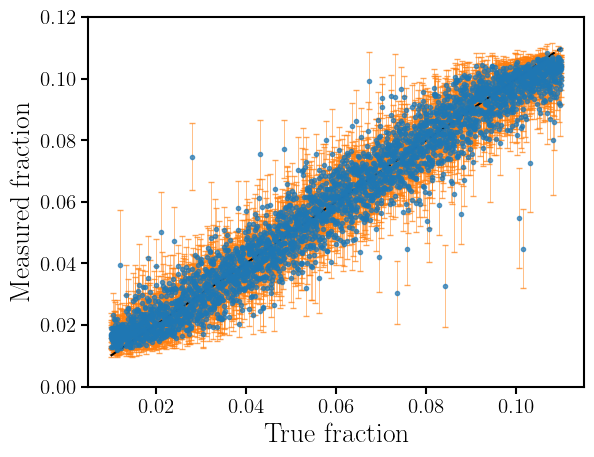

MSE error: 4.878677e-05
6
Reduced chi2: 1.3332867452128472


In [38]:
j = 2**15

ks, labels, lenk = NINf.load_Pkf("inbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, n_load=j)
print(lenk)
max_corr = labels[:,:-1].max(axis=0)
min_corr = labels[:,:-1].min(axis=0)

Pks, labels, lenk = NINf.load_Pkf("inbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, norm_c=True, n_load=j)

##Priors
Pk_paths = pd.read_csv("inbox_all-fs-RSD-BSQ.csv")

sP = {'sigma_8': 0.0060, 'Omega_m': 0.0056, 'h': 0.0042, 'n_s': 0.0038, 'Omega_b': 0.0008} #from Table 2 in Planck 2018 (1807.06209)
priors = ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
len_priors = len(priors)
np.random.seed(j) #for reproducibility of the MSE and plots
r = np.random.normal(size=(len(Pks), len_priors))
cosmo_p = np.zeros((len(Pks), len_priors))

for i, prior in enumerate(priors):
    if len_priors == 1:
        cosmo_p = np.reshape(Pk_paths[prior],((len(Pks),1))) + r * sP[prior] * 0. #0 times Planck
    else:
        cosmo_p[:,i] = Pk_paths[prior][:j] + r[:,i] * sP[prior] * 0. #0 times Planck

Pks = np.hstack((Pks, cosmo_p)) #I also normalize cosmo_p between 0 and 1
#Loading max min

n = f'NoInterNet-Logloss-P0-P0-allprior0P-{j:d}-moments' if j != 2**15 else 'NoInterNet-Logloss-P0-P0-allprior0P-BSQ-moments'

min_Pks, max_Pks = np.loadtxt("../trained-model/BSQ/RSD/inbox/" + n + "/maxmin.dat", unpack=True)
Pks = NINf.maxmin_corr(Pks, max_Pks, min_Pks)
norm = np.ones(len(Pks))

fs = labels[:,-1]

_, ind = np.unique(fs, return_index=True)
f_u = np.array([fs[indx] for indx in sorted(ind)]) #non ordered unique interloper fraction array

n_train = int(len(f_u)*0.75)
n_val = int(len(f_u)*0.9)

fs_test = (f_u[n_val:])

sel_test = np.array([], dtype=int)

for f in fs_test: sel_test= np.append(sel_test, np.where(fs == f)[0])

Pks_test = Pks[sel_test]
labels_test = labels[sel_test]

norm_test = np.array(norm[sel_test, np.newaxis])

test = NIN.PkDataset(Pks_test, labels_test, norm_test)

test_batch = 10
test_dataloader = DataLoader(test, batch_size=test_batch, shuffle=True)
model = NINf.NoInterNet_fraction_compress_inference(lenk+5, 64, lenk, 64, n_min=16).to(device)
NIN.resume(model, "../trained-model/BSQ/RSD/inbox/" + n + "/best_model-64.pth", device)
print(j)
plot_fraction(test, model, lenk=lenk, device=device, norm_fs=True, save=None)
chi2(test, model, lenk=lenk, device=device, norm_fs=True, thresh=1e-3)

/tmp/ipykernel_51685/3810797402.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.,0.6)


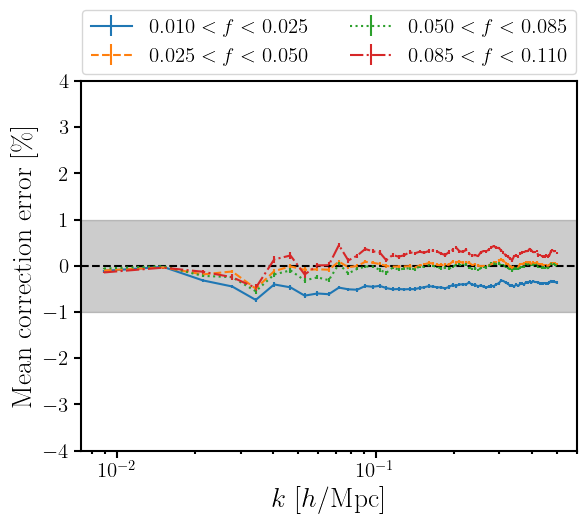

In [39]:
ks = np.loadtxt('ks-gris.dat')

p_mean1, y_mean1, std_mean1, m1, sm1, N1 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.001, 0.025, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean2, y_mean2, std_mean2, m2, sm2, N2 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.025, 0.050, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean3, y_mean3, std_mean3, m3, sm3, N3 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.050, 0.085, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean4, y_mean4, std_mean4, m4, sm4, N4 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.085, 0.110, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)

sel = (ks> 0.) & (ks < 0.5)
k_plot = ks[sel]

plt.errorbar(k_plot, m1[:lenk] * 100., yerr=sm1[:lenk]*100., label='$0.010 < f < 0.025$', linestyle='solid')
plt.errorbar(k_plot, m2[:lenk] * 100., yerr=sm2[:lenk]*100., label='$0.025 < f < 0.050$', linestyle='dashed')
plt.errorbar(k_plot, m3[:lenk] * 100., yerr=sm3[:lenk]*100., label='$0.050 < f < 0.085$', linestyle='dotted')
plt.errorbar(k_plot, m4[:lenk] * 100., yerr=sm4[:lenk]*100., label='$0.085 < f < 0.110$', linestyle='dashdot')

plt.axhline(0, color='k', linestyle='dashed')
plt.xscale('log')
plt.xlabel('$k$ [$h$/Mpc]')
plt.ylim(-4.,4.)
plt.xlim(0.,0.6)
plt.ylabel('''Mean correction error [$\\%$]''')

plt.fill_between([0., .6], -1, 1, alpha=.2, color='k')

plt.legend(ncols=2, loc='lower center', bbox_to_anchor=(0.5,0.99))
#plt.tight_layout()
plt.show()

### 1 Planck prior

79
1 64 32
2 32 16
3 16 32
4 32 64
32768


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

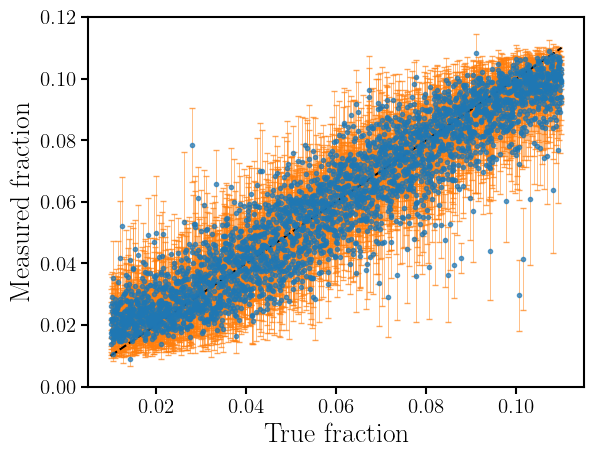

MSE error: 0.000104573875
1
Reduced chi2: 1.0833142361773345


In [40]:
j = 2**15

ks, labels, lenk = NINf.load_Pkf("inbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, n_load=j)
print(lenk)
max_corr = labels[:,:-1].max(axis=0)
min_corr = labels[:,:-1].min(axis=0)

Pks, labels, lenk = NINf.load_Pkf("inbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, norm_c=True, n_load=j)

##Priors
Pk_paths = pd.read_csv("inbox_all-fs-RSD-BSQ.csv")

sP = {'sigma_8': 0.0060, 'Omega_m': 0.0056, 'h': 0.0042, 'n_s': 0.0038, 'Omega_b': 0.0008} #from Table 2 in Planck 2018 (1807.06209)
priors = ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
len_priors = len(priors)
np.random.seed(j) #for reproducibility of the MSE and plots
r = np.random.normal(size=(len(Pks), len_priors))
cosmo_p = np.zeros((len(Pks), len_priors))

for i, prior in enumerate(priors):
    if len_priors == 1:
        cosmo_p = np.reshape(Pk_paths[prior],((len(Pks),1))) + r * sP[prior] * 1. #3 times Planck
    else:
        cosmo_p[:,i] = Pk_paths[prior][:j] + r[:,i] * sP[prior] * 1. #3 times Planck

#print(cosmo_p)

Pks = np.hstack((Pks, cosmo_p)) #I also normalize cosmo_p between 0 and 1
#Loading max min

n = f'NoInterNet-Logloss-P0-P0-allprior1P-{j:d}-moments' if j != 2**15 else 'NoInterNet-Logloss-P0-P0-allprior1P-BSQ-moments'

min_Pks, max_Pks = np.loadtxt("../trained-model/BSQ/RSD/inbox/" + n + "/maxmin.dat", unpack=True)
Pks = NINf.maxmin_corr(Pks, max_Pks, min_Pks)
norm = np.ones(len(Pks))

fs = labels[:,-1]

_, ind = np.unique(fs, return_index=True)
f_u = np.array([fs[indx] for indx in sorted(ind)]) #non ordered unique interloper fraction array

n_train = int(len(f_u)*0.75)
n_val = int(len(f_u)*0.9)

fs_test = (f_u[n_val:])

sel_test = np.array([], dtype=int)

for f in fs_test: sel_test= np.append(sel_test, np.where(fs == f)[0])

Pks_test = Pks[sel_test]
labels_test = labels[sel_test]

norm_test = np.array(norm[sel_test, np.newaxis])

test = NIN.PkDataset(Pks_test, labels_test, norm_test)

test_batch = 10
test_dataloader = DataLoader(test, batch_size=test_batch, shuffle=True)
model = NINf.NoInterNet_fraction_compress_inference(lenk+5, 64, lenk, 64, n_min=16).to(device)
NIN.resume(model, "../trained-model/BSQ/RSD/inbox/" + n + "/best_model-64.pth", device)
print(j)
plot_fraction(test, model, lenk=lenk, device=device, norm_fs=True, save=None)
chi2(test, model, lenk=lenk, device=device, norm_fs=True, thresh=1e-3)

/tmp/ipykernel_51685/3810797402.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.,0.6)


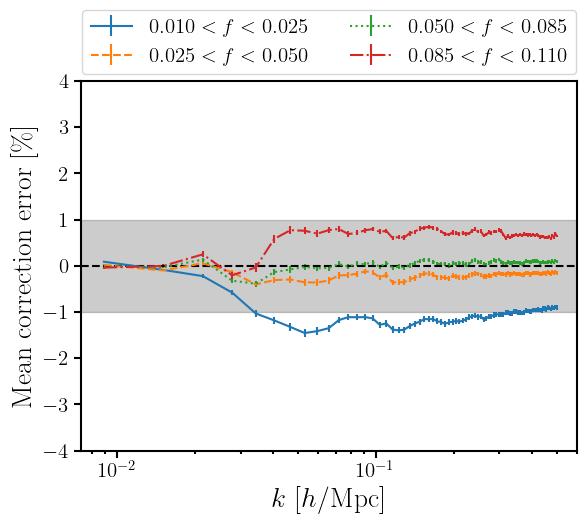

In [41]:
ks = np.loadtxt('ks-gris.dat')

p_mean1, y_mean1, std_mean1, m1, sm1, N1 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.001, 0.025, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean2, y_mean2, std_mean2, m2, sm2, N2 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.025, 0.050, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean3, y_mean3, std_mean3, m3, sm3, N3 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.050, 0.085, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean4, y_mean4, std_mean4, m4, sm4, N4 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.085, 0.110, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)

sel = (ks> 0.) & (ks < 0.5)
k_plot = ks[sel]

plt.errorbar(k_plot, m1[:lenk] * 100., yerr=sm1[:lenk]*100., label='$0.010 < f < 0.025$', linestyle='solid')
plt.errorbar(k_plot, m2[:lenk] * 100., yerr=sm2[:lenk]*100., label='$0.025 < f < 0.050$', linestyle='dashed')
plt.errorbar(k_plot, m3[:lenk] * 100., yerr=sm3[:lenk]*100., label='$0.050 < f < 0.085$', linestyle='dotted')
plt.errorbar(k_plot, m4[:lenk] * 100., yerr=sm4[:lenk]*100., label='$0.085 < f < 0.110$', linestyle='dashdot')

plt.axhline(0, color='k', linestyle='dashed')
plt.xscale('log')
plt.xlabel('$k$ [$h$/Mpc]')
plt.ylim(-4.,4.)
plt.xlim(0.,0.6)
plt.ylabel('''Mean correction error [$\\%$]''')

plt.fill_between([0., .6], -1, 1, alpha=.2, color='k')

plt.legend(ncols=2, loc='lower center', bbox_to_anchor=(0.5,0.99))
#plt.tight_layout()
plt.show()

### 3 Planck prior

I plot the fraction scatter for all the training set $N$ and the correction only for the largest one

In [42]:
for j in N:
    ks, labels, lenk = NINf.load_Pkf("inbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, n_load=j)
    print(lenk)
    max_corr = labels[:,:-1].max(axis=0)
    min_corr = labels[:,:-1].min(axis=0)
    
    Pks, labels, lenk = NINf.load_Pkf("inbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, norm_c=True, n_load=j)
    
    ##Priors
    Pk_paths = pd.read_csv("inbox_all-fs-RSD-BSQ.csv")
    
    sP = {'sigma_8': 0.0060, 'Omega_m': 0.0056, 'h': 0.0042, 'n_s': 0.0038, 'Omega_b': 0.0008} #from Table 2 in Planck 2018 (1807.06209)
    priors = ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
    len_priors = len(priors)
    np.random.seed(j) #for reproducibility of the MSE and plots
    r = np.random.normal(size=(len(Pks), len_priors))
    cosmo_p = np.zeros((len(Pks), len_priors))
    
    for i, prior in enumerate(priors):
        if len_priors == 1:
            cosmo_p = np.reshape(Pk_paths[prior],((len(Pks),1))) + r * sP[prior] * 3. #3 times Planck
        else:
            cosmo_p[:,i] = Pk_paths[prior][:j] + r[:,i] * sP[prior] * 3. #3 times Planck
    
    #print(cosmo_p)
    
    Pks = np.hstack((Pks, cosmo_p)) #I also normalize cosmo_p between 0 and 1
    #Loading max min
    
    n = f'NoInterNet-Logloss-P0-P0-allprior3P-{j:d}-moments' if j != 2**15 else 'NoInterNet-Logloss-P0-P0-allprior3P-BSQ-moments'
    
    min_Pks, max_Pks = np.loadtxt("../trained-model/BSQ/RSD/inbox/" + n + "/maxmin.dat", unpack=True)
    Pks = NINf.maxmin_corr(Pks, max_Pks, min_Pks)
    norm = np.ones(len(Pks))
    
    fs = labels[:,-1]
    
    _, ind = np.unique(fs, return_index=True)
    f_u = np.array([fs[indx] for indx in sorted(ind)]) #non ordered unique interloper fraction array
    
    n_train = int(len(f_u)*0.75)
    n_val = int(len(f_u)*0.9)
    
    fs_test = (f_u[n_val:])
    
    sel_test = np.array([], dtype=int)
    
    for f in fs_test: sel_test= np.append(sel_test, np.where(fs == f)[0])
    
    Pks_test = Pks[sel_test]
    labels_test = labels[sel_test]
    
    norm_test = np.array(norm[sel_test, np.newaxis])
    
    test = NIN.PkDataset(Pks_test, labels_test, norm_test)
    
    test_batch = 10
    test_dataloader = DataLoader(test, batch_size=test_batch, shuffle=True)

    model = NINf.NoInterNet_fraction_compress_inference(lenk+5, 64, lenk, 64, n_min=16).to(device)
    NIN.resume(model, "../trained-model/BSQ/RSD/inbox/" + n + "/best_model-64.pth", device)

    print(j)
    #plot_fraction(test, model, lenk=lenk, device=device, norm_fs=True, save=None)
    chi2(test, model, lenk=lenk, device=device, norm_fs=True, thresh=1e-3)
    

79
1 64 32
2 32 16
3 16 32
4 32 64
512
0
Reduced chi2: 3.6079512376051683


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
1024
0
Reduced chi2: 5.386740082675971


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
2048
0
Reduced chi2: 2.5386269173971034


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
4096
0
Reduced chi2: 1.9685579625571645


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
8192
1
Reduced chi2: 3.3300727658155487


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
16384
0
Reduced chi2: 1.163573622921751


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
32768
3
Reduced chi2: 1.2934801266402196


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

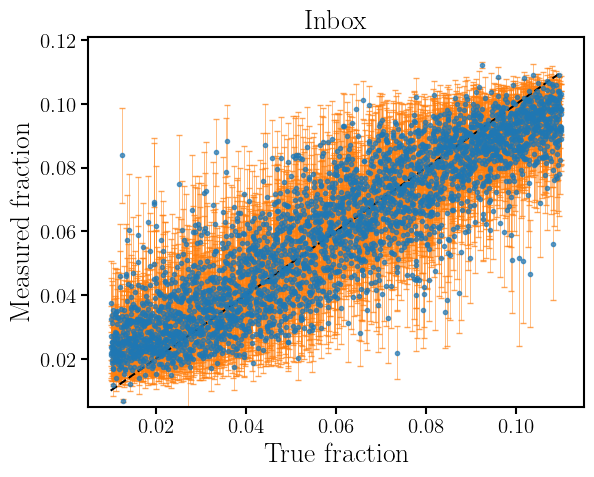

MSE error: 0.00017476936


In [43]:
plot_fraction(test, model, lenk=lenk, device=device, norm_fs=True, limits=[0.005, 0.121], title='Inbox')#, save='../figures/fraction-scatter-inbox-P0-P0.png'

/tmp/ipykernel_51685/1364212096.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.,0.6)


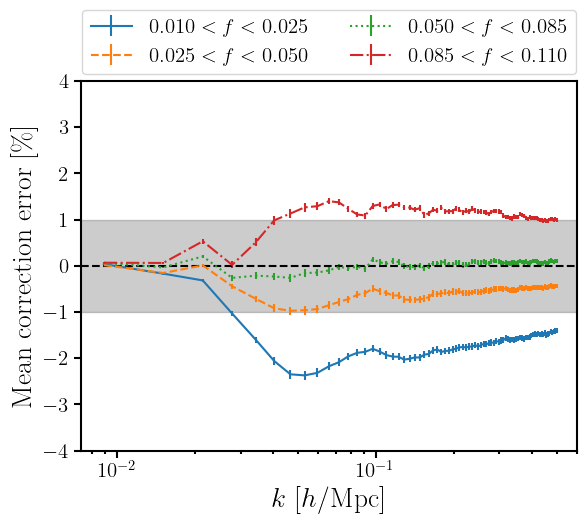

In [44]:
ks = np.loadtxt('ks-gris.dat')

p_mean1, y_mean1, std_mean1, m1, sm1, N1 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.001, 0.025, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean2, y_mean2, std_mean2, m2, sm2, N2 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.025, 0.050, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean3, y_mean3, std_mean3, m3, sm3, N3 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.050, 0.085, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean4, y_mean4, std_mean4, m4, sm4, N4 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.085, 0.110, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)

sel = (ks> 0.) & (ks < 0.5)
k_plot = ks[sel]

plt.errorbar(k_plot, m1[:lenk] * 100., yerr=sm1[:lenk]*100., label='$0.010 < f < 0.025$', linestyle='solid')
plt.errorbar(k_plot, m2[:lenk] * 100., yerr=sm2[:lenk]*100., label='$0.025 < f < 0.050$', linestyle='dashed')
plt.errorbar(k_plot, m3[:lenk] * 100., yerr=sm3[:lenk]*100., label='$0.050 < f < 0.085$', linestyle='dotted')
plt.errorbar(k_plot, m4[:lenk] * 100., yerr=sm4[:lenk]*100., label='$0.085 < f < 0.110$', linestyle='dashdot')

plt.axhline(0, color='k', linestyle='dashed')
plt.xscale('log')
plt.xlabel('$k$ [$h$/Mpc]')
plt.ylim(-4.,4.)
plt.xlim(0.,0.6)
plt.ylabel('''Mean correction error [$\\%$]''')

plt.fill_between([0., .6], -1, 1, alpha=.2, color='k')

plt.legend(ncols=2, loc='lower center', bbox_to_anchor=(0.5,0.99))
#plt.tight_layout()
#plt.savefig('../figures/MCE-inbox-BSQ-P0-P0-3P.pdf', bbox_inches='tight')
plt.show()


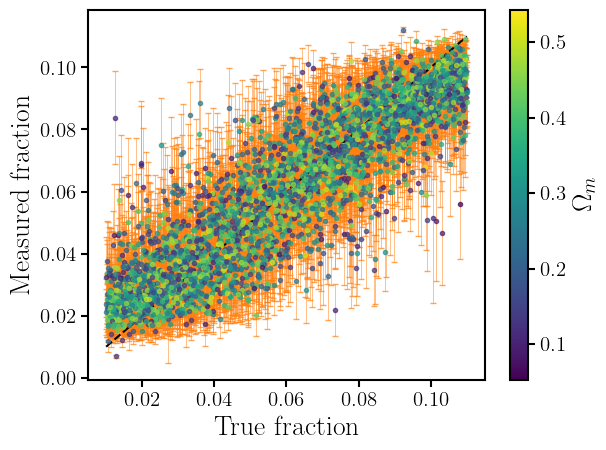

MSE error: 0.00017476939


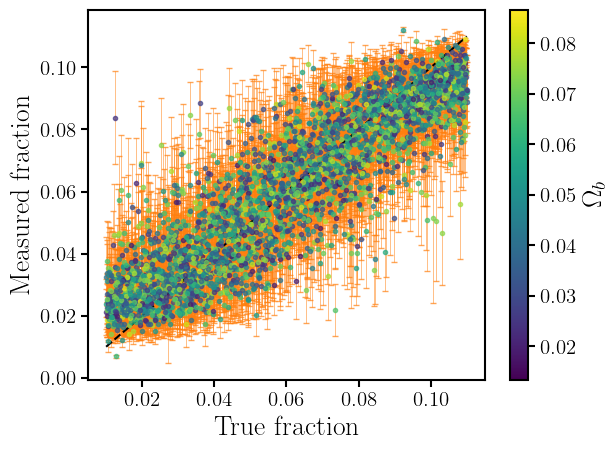

MSE error: 0.00017476936


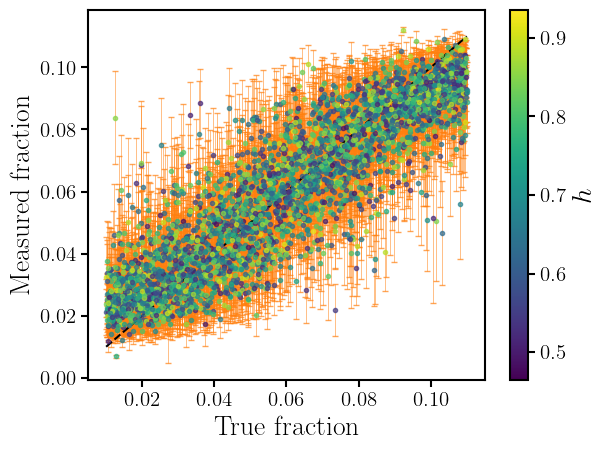

MSE error: 0.00017476936


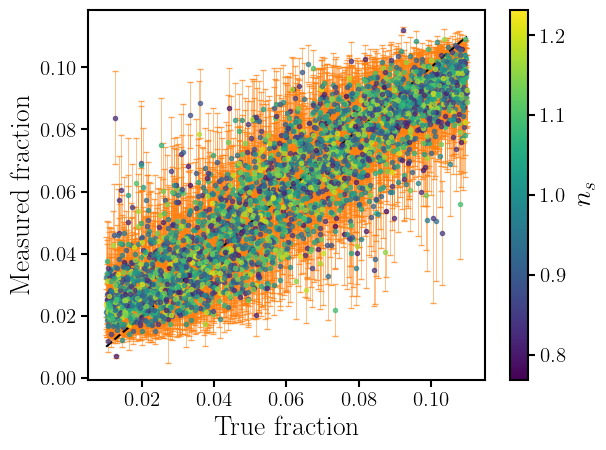

MSE error: 0.00017476936


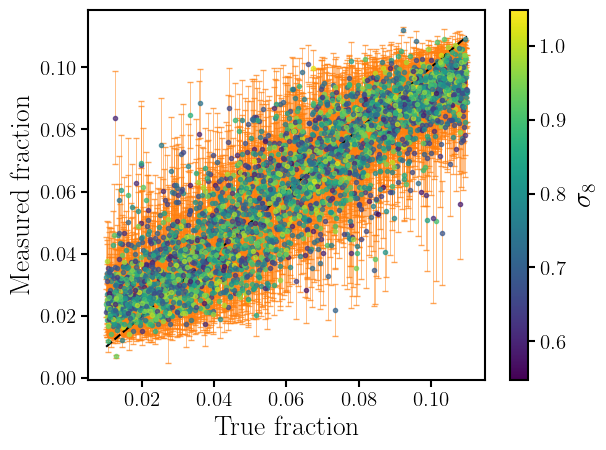

MSE error: 0.00017476936


In [45]:
plot_fraction_cosmocolor(test, model, lenk=lenk, device=device, cosmo_ind=-5, cosmo_name='$\\Omega_m$', norm_fs=True, save=None, max_corr=max_Pks, min_corr=min_Pks)
plot_fraction_cosmocolor(test, model, lenk=lenk, device=device, cosmo_ind=-4, cosmo_name='$\\Omega_b$', norm_fs=True, save=None, max_corr=max_Pks, min_corr=min_Pks)
plot_fraction_cosmocolor(test, model, lenk=lenk, device=device, cosmo_ind=-3, cosmo_name='$h$', norm_fs=True, save=None, max_corr=max_Pks, min_corr=min_Pks)
plot_fraction_cosmocolor(test, model, lenk=lenk, device=device, cosmo_ind=-2, cosmo_name='$n_s$', norm_fs=True, save=None, max_corr=max_Pks, min_corr=min_Pks)
plot_fraction_cosmocolor(test, model, lenk=lenk, device=device, cosmo_ind=-1, cosmo_name='$\\sigma_8$', norm_fs=True, save=None, max_corr=max_Pks, min_corr=min_Pks)


### 5 Planck prior

I plot the fraction scatter for all the training set $N$ and the correction only for the largest one

In [68]:
for j in N:
    ks, labels, lenk = NINf.load_Pkf("inbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, n_load=j)
    print(lenk)
    max_corr = labels[:,:-1].max(axis=0)
    min_corr = labels[:,:-1].min(axis=0)
    
    Pks, labels, lenk = NINf.load_Pkf("inbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, norm_c=True, n_load=j)
    
    ##Priors
    Pk_paths = pd.read_csv("inbox_all-fs-RSD-BSQ.csv")
    
    sP = {'sigma_8': 0.0060, 'Omega_m': 0.0056, 'h': 0.0042, 'n_s': 0.0038, 'Omega_b': 0.0008} #from Table 2 in Planck 2018 (1807.06209)
    priors = ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
    len_priors = len(priors)
    np.random.seed(j) #for reproducibility of the MSE and plots
    r = np.random.normal(size=(len(Pks), len_priors))
    cosmo_p = np.zeros((len(Pks), len_priors))
    
    for i, prior in enumerate(priors):
        if len_priors == 1:
            cosmo_p = np.reshape(Pk_paths[prior],((len(Pks),1))) + r * sP[prior] * 5. #5 times Planck
        else:
            cosmo_p[:,i] = Pk_paths[prior][:j] + r[:,i] * sP[prior] * 5. #5 times Planck
    
    #print(cosmo_p)
    
    Pks = np.hstack((Pks, cosmo_p)) #I also normalize cosmo_p between 0 and 1
    #Loading max min
    
    n = f'NoInterNet-Logloss-P0-P0-allprior5P-{j:d}-moments' if j != 2**15 else 'NoInterNet-Logloss-P0-P0-allprior5P-BSQ-moments'
    
    min_Pks, max_Pks = np.loadtxt("../trained-model/BSQ/RSD/inbox/" + n + "/maxmin.dat", unpack=True)
    Pks = NINf.maxmin_corr(Pks, max_Pks, min_Pks)
    norm = np.ones(len(Pks))
    
    fs = labels[:,-1]
    
    _, ind = np.unique(fs, return_index=True)
    f_u = np.array([fs[indx] for indx in sorted(ind)]) #non ordered unique interloper fraction array
    
    n_train = int(len(f_u)*0.75)
    n_val = int(len(f_u)*0.9)
    
    fs_test = (f_u[n_val:])
    
    sel_test = np.array([], dtype=int)
    
    for f in fs_test: sel_test= np.append(sel_test, np.where(fs == f)[0])
    
    Pks_test = Pks[sel_test]
    labels_test = labels[sel_test]
    
    norm_test = np.array(norm[sel_test, np.newaxis])
    
    test = NIN.PkDataset(Pks_test, labels_test, norm_test)
    
    test_batch = 10
    test_dataloader = DataLoader(test, batch_size=test_batch, shuffle=True)

    model = NINf.NoInterNet_fraction_compress_inference(lenk+5, 64, lenk, 64, n_min=16).to(device)
    NIN.resume(model, "../trained-model/BSQ/RSD/inbox/" + n + "/best_model-64.pth", device)

    print(j)
    #plot_fraction(test, model, lenk=lenk, device=device, norm_fs=True, save=None)
    chi2(test, model, lenk=lenk, device=device, norm_fs=True, thresh=1e-3)

79
1 64 32
2 32 16
3 16 32
4 32 64
512
0
Reduced chi2: 1.0485353469848633


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
1024
0
Reduced chi2: 9.482293878944175


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
2048
0
Reduced chi2: 1.3823879334984757


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
4096
0
Reduced chi2: 3.792336961699695


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
8192
0
Reduced chi2: 1.4568532059832318


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
16384
0
Reduced chi2: 1.3835096190512508


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79
1 64 32
2 32 16
3 16 32
4 32 64
32768
2
Reduced chi2: 1.6613017813548978


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

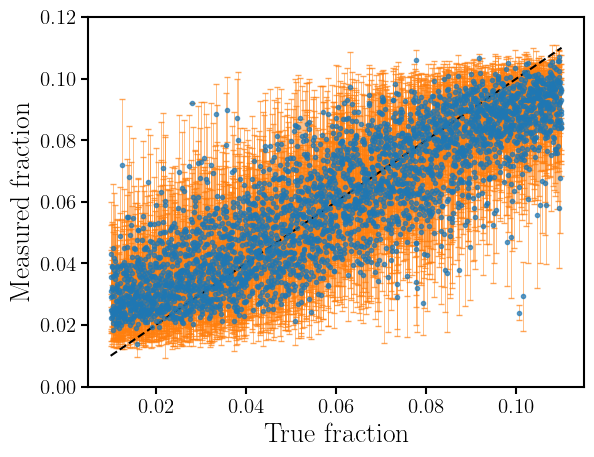

MSE error: 0.00022897897


In [69]:
plot_fraction(test, model, lenk=lenk, device=device, norm_fs=True, save=None)

/tmp/ipykernel_51685/3810797402.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.,0.6)


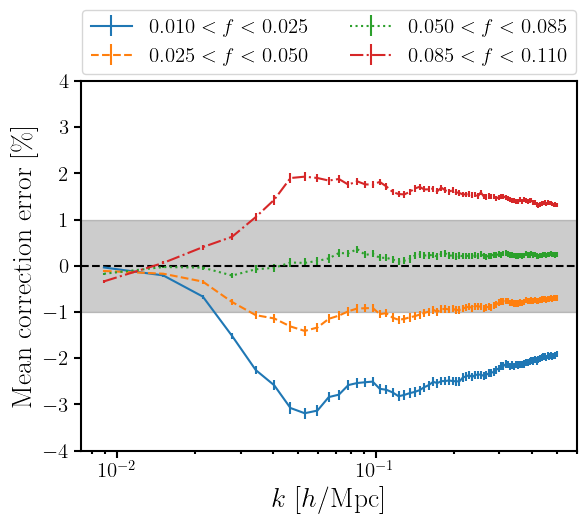

In [70]:
ks = np.loadtxt('ks-gris.dat')

p_mean1, y_mean1, std_mean1, m1, sm1, N1 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.001, 0.025, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean2, y_mean2, std_mean2, m2, sm2, N2 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.025, 0.050, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean3, y_mean3, std_mean3, m3, sm3, N3 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.050, 0.085, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean4, y_mean4, std_mean4, m4, sm4, N4 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.085, 0.110, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)

sel = (ks> 0.) & (ks < 0.5)
k_plot = ks[sel]

plt.errorbar(k_plot, m1[:lenk] * 100., yerr=sm1[:lenk]*100., label='$0.010 < f < 0.025$', linestyle='solid')
plt.errorbar(k_plot, m2[:lenk] * 100., yerr=sm2[:lenk]*100., label='$0.025 < f < 0.050$', linestyle='dashed')
plt.errorbar(k_plot, m3[:lenk] * 100., yerr=sm3[:lenk]*100., label='$0.050 < f < 0.085$', linestyle='dotted')
plt.errorbar(k_plot, m4[:lenk] * 100., yerr=sm4[:lenk]*100., label='$0.085 < f < 0.110$', linestyle='dashdot')

plt.axhline(0, color='k', linestyle='dashed')
plt.xscale('log')
plt.xlabel('$k$ [$h$/Mpc]')
plt.ylim(-4.,4.)
plt.xlim(0.,0.6)
plt.ylabel('''Mean correction error [$\\%$]''')

plt.fill_between([0., .6], -1, 1, alpha=.2, color='k')

plt.legend(ncols=2, loc='lower center', bbox_to_anchor=(0.5,0.99))
#plt.tight_layout()
plt.show()

## P0B0 -> P0

#### 0 Planck prior 

79 294
1 64 32
2 32 16
3 16 32
4 32 64
32768


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

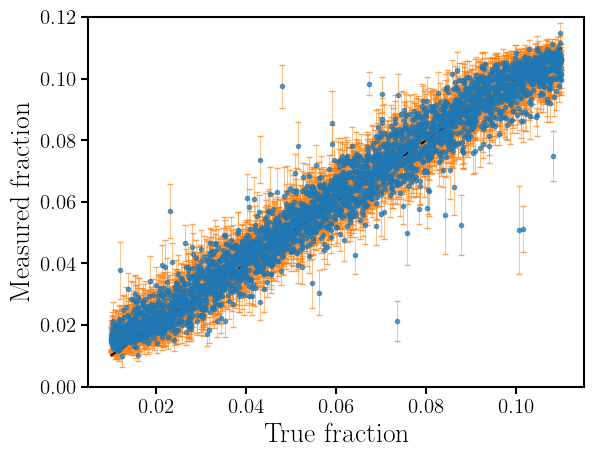

MSE error: 3.7738202e-05
0
Reduced chi2: 1.223366619502403


In [66]:
j = 2**15

PBs, labels, lenP, lenB = NINf.load_PBf("inbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, n_load=j)
print(lenP, lenB)
max_corr = labels[:,:-1].max(axis=0)
min_corr = labels[:,:-1].min(axis=0)

PBs, labels, lenP, lenB = NINf.load_PBf("inbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, norm_c=True, n_load=j)

##Priors
Pk_paths = pd.read_csv("inbox_all-fs-RSD-BSQ.csv")

sP = {'sigma_8': 0.0060, 'Omega_m': 0.0056, 'h': 0.0042, 'n_s': 0.0038, 'Omega_b': 0.0008} #from Table 2 in Planck 2018 (1807.06209)
priors = ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
len_priors = len(priors)
np.random.seed(j) #for reproducibility of the MSE and plots
r = np.random.normal(size=(len(PBs), len_priors))
cosmo_p = np.zeros((len(PBs), len_priors))

for i, prior in enumerate(priors):
    if len_priors == 1:
        cosmo_p = np.reshape(Pk_paths[prior],((len(PBs),1))) + r * sP[prior] * 0. #0 times Planck
    else:
        cosmo_p[:,i] = Pk_paths[prior][:j] + r[:,i] * sP[prior] * 0. #0 times Planck

#print(cosmo_p)

PBs = np.hstack((PBs, cosmo_p)) #I also normalize cosmo_p between 0 and 1
#Loading max min

n = f'NoInterNet-Logloss-P0B0-P0-allprior0P-{j:d}-moments' if j != 2**15 else 'NoInterNet-Logloss-P0B0-P0-allprior0P-BSQ-moments'
min_PBs, max_PBs = np.loadtxt("../trained-model/BSQ/RSD/inbox/" + n + "/maxmin.dat", unpack=True)
PBs = NINf.maxmin_corr(PBs, max_PBs, min_PBs)
norm = np.ones(len(PBs))

fs = labels[:,-1]

_, ind = np.unique(fs, return_index=True)
f_u = np.array([fs[indx] for indx in sorted(ind)]) #non ordered unique interloper fraction array

n_train = int(len(f_u)*0.75)
n_val = int(len(f_u)*0.9)

fs_test = (f_u[n_val:])

sel_test = np.array([], dtype=int)
    
for f in fs_test: sel_test= np.append(sel_test, np.where(fs == f)[0])

PBs_test = PBs[sel_test]
labels_test = labels[sel_test]

norm_test = np.array(norm[sel_test, np.newaxis])

test = NIN.PkDataset(PBs_test, labels_test, norm_test)

test_batch = 10
test_dataloader = DataLoader(test, batch_size=test_batch, shuffle=True)
model = NINf.NoInterNet_fraction_compress_inference(lenP+lenB+5, 64, lenP, 64, n_min=16).to(device)
NIN.resume(model, "../trained-model/BSQ/RSD/inbox/" + n + "/best_model-64.pth", device)
print(j)
plot_fraction(test, model, lenk=lenP, device=device, norm_fs=True, save=None)
chi2(test, model, lenk=lenP, device=device, norm_fs=True, thresh=1e-3)
    

/tmp/ipykernel_51685/3810797402.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.,0.6)


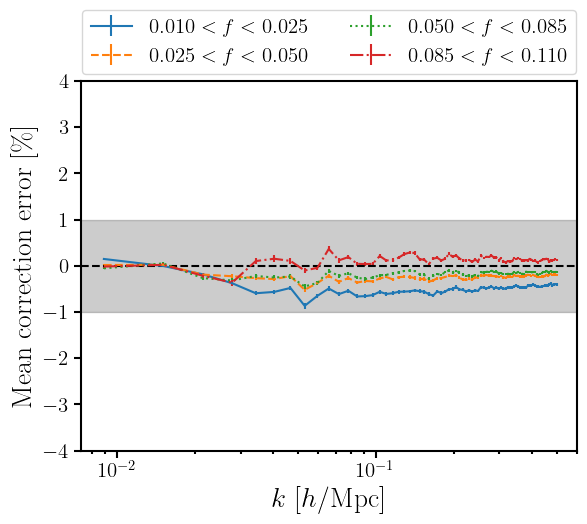

In [67]:
ks = np.loadtxt('ks-gris.dat')

p_mean1, y_mean1, std_mean1, m1, sm1, N1 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.001, 0.025, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean2, y_mean2, std_mean2, m2, sm2, N2 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.025, 0.050, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean3, y_mean3, std_mean3, m3, sm3, N3 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.050, 0.085, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean4, y_mean4, std_mean4, m4, sm4, N4 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.085, 0.110, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)

sel = (ks> 0.) & (ks < 0.5)
k_plot = ks[sel]

plt.errorbar(k_plot, m1[:lenk] * 100., yerr=sm1[:lenk]*100., label='$0.010 < f < 0.025$', linestyle='solid')
plt.errorbar(k_plot, m2[:lenk] * 100., yerr=sm2[:lenk]*100., label='$0.025 < f < 0.050$', linestyle='dashed')
plt.errorbar(k_plot, m3[:lenk] * 100., yerr=sm3[:lenk]*100., label='$0.050 < f < 0.085$', linestyle='dotted')
plt.errorbar(k_plot, m4[:lenk] * 100., yerr=sm4[:lenk]*100., label='$0.085 < f < 0.110$', linestyle='dashdot')

plt.axhline(0, color='k', linestyle='dashed')
plt.xscale('log')
plt.xlabel('$k$ [$h$/Mpc]')
plt.ylim(-4.,4.)
plt.xlim(0.,0.6)
plt.ylabel('''Mean correction error [$\\%$]''')

plt.fill_between([0., .6], -1, 1, alpha=.2, color='k')

plt.legend(ncols=2, loc='lower center', bbox_to_anchor=(0.5,0.99))
#plt.tight_layout()
plt.show()

#### 1 Planck prior 

79 294
1 64 32
2 32 16
3 16 32
4 32 64
32768


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

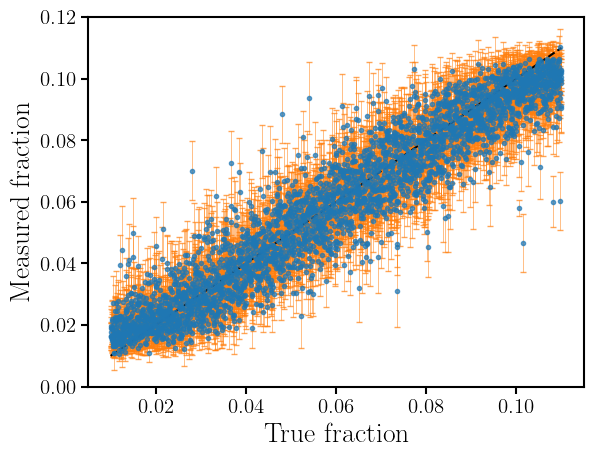

MSE error: 8.172555e-05
0
Reduced chi2: 1.330473726684086


In [54]:
j = 2**15

PBs, labels, lenP, lenB = NINf.load_PBf("inbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, n_load=j)
print(lenP, lenB)
max_corr = labels[:,:-1].max(axis=0)
min_corr = labels[:,:-1].min(axis=0)

PBs, labels, lenP, lenB = NINf.load_PBf("inbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, norm_c=True, n_load=j)

##Priors
Pk_paths = pd.read_csv("inbox_all-fs-RSD-BSQ.csv")

sP = {'sigma_8': 0.0060, 'Omega_m': 0.0056, 'h': 0.0042, 'n_s': 0.0038, 'Omega_b': 0.0008} #from Table 2 in Planck 2018 (1807.06209)
priors = ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
len_priors = len(priors)
np.random.seed(j) #for reproducibility of the MSE and plots
r = np.random.normal(size=(len(PBs), len_priors))
cosmo_p = np.zeros((len(PBs), len_priors))

for i, prior in enumerate(priors):
    if len_priors == 1:
        cosmo_p = np.reshape(Pk_paths[prior],((len(PBs),1))) + r * sP[prior] * 1. #3 times Planck
    else:
        cosmo_p[:,i] = Pk_paths[prior][:j] + r[:,i] * sP[prior] * 1. #3 times Planck

#print(cosmo_p)

PBs = np.hstack((PBs, cosmo_p)) #I also normalize cosmo_p between 0 and 1
#Loading max min

n = f'NoInterNet-Logloss-P0B0-P0-allprior1P-{j:d}-moments' if j != 2**15 else 'NoInterNet-Logloss-P0B0-P0-allprior1P-BSQ-moments'
min_PBs, max_PBs = np.loadtxt("../trained-model/BSQ/RSD/inbox/" + n + "/maxmin.dat", unpack=True)
PBs = NINf.maxmin_corr(PBs, max_PBs, min_PBs)
norm = np.ones(len(PBs))

fs = labels[:,-1]

_, ind = np.unique(fs, return_index=True)
f_u = np.array([fs[indx] for indx in sorted(ind)]) #non ordered unique interloper fraction array

n_train = int(len(f_u)*0.75)
n_val = int(len(f_u)*0.9)

fs_test = (f_u[n_val:])

sel_test = np.array([], dtype=int)
    
for f in fs_test: sel_test= np.append(sel_test, np.where(fs == f)[0])

PBs_test = PBs[sel_test]
labels_test = labels[sel_test]

norm_test = np.array(norm[sel_test, np.newaxis])

test = NIN.PkDataset(PBs_test, labels_test, norm_test)

test_batch = 10
test_dataloader = DataLoader(test, batch_size=test_batch, shuffle=True)
model = NINf.NoInterNet_fraction_compress_inference(lenP+lenB+5, 64, lenP, 64, n_min=16).to(device)
NIN.resume(model, "../trained-model/BSQ/RSD/inbox/" + n + "/best_model-64.pth", device)
print(j)
plot_fraction(test, model, lenk=lenP, device=device, norm_fs=True, save=None)
chi2(test, model, lenk=lenP, device=device, norm_fs=True, thresh=1e-3)
    

/tmp/ipykernel_51685/3810797402.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.,0.6)


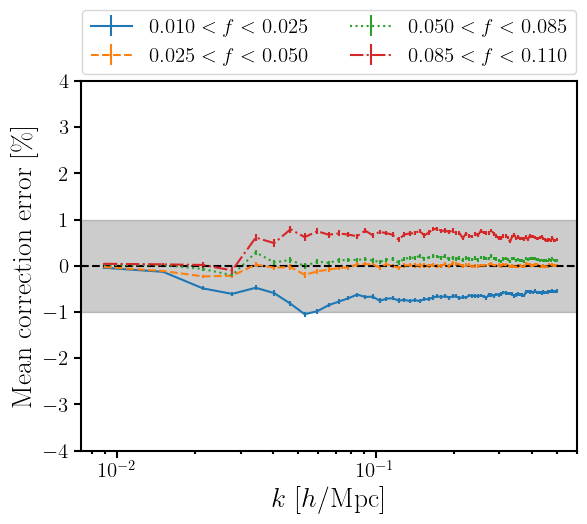

In [55]:
ks = np.loadtxt('ks-gris.dat')

p_mean1, y_mean1, std_mean1, m1, sm1, N1 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.001, 0.025, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean2, y_mean2, std_mean2, m2, sm2, N2 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.025, 0.050, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean3, y_mean3, std_mean3, m3, sm3, N3 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.050, 0.085, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean4, y_mean4, std_mean4, m4, sm4, N4 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.085, 0.110, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)

sel = (ks> 0.) & (ks < 0.5)
k_plot = ks[sel]

plt.errorbar(k_plot, m1[:lenk] * 100., yerr=sm1[:lenk]*100., label='$0.010 < f < 0.025$', linestyle='solid')
plt.errorbar(k_plot, m2[:lenk] * 100., yerr=sm2[:lenk]*100., label='$0.025 < f < 0.050$', linestyle='dashed')
plt.errorbar(k_plot, m3[:lenk] * 100., yerr=sm3[:lenk]*100., label='$0.050 < f < 0.085$', linestyle='dotted')
plt.errorbar(k_plot, m4[:lenk] * 100., yerr=sm4[:lenk]*100., label='$0.085 < f < 0.110$', linestyle='dashdot')

plt.axhline(0, color='k', linestyle='dashed')
plt.xscale('log')
plt.xlabel('$k$ [$h$/Mpc]')
plt.ylim(-4.,4.)
plt.xlim(0.,0.6)
plt.ylabel('''Mean correction error [$\\%$]''')

plt.fill_between([0., .6], -1, 1, alpha=.2, color='k')

plt.legend(ncols=2, loc='lower center', bbox_to_anchor=(0.5,0.99))
#plt.tight_layout()
plt.show()

#### 3 Planck prior

I plot the fraction scatter for all the training set $N$ and the correction only for the largest one

In [56]:
for j in N:
    PBs, labels, lenP, lenB = NINf.load_PBf("inbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, n_load=j)
    print(lenP, lenB)
    max_corr = labels[:,:-1].max(axis=0)
    min_corr = labels[:,:-1].min(axis=0)
    
    PBs, labels, lenP, lenB = NINf.load_PBf("inbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, norm_c=True, n_load=j)
    
    ##Priors
    Pk_paths = pd.read_csv("inbox_all-fs-RSD-BSQ.csv")
    
    sP = {'sigma_8': 0.0060, 'Omega_m': 0.0056, 'h': 0.0042, 'n_s': 0.0038, 'Omega_b': 0.0008} #from Table 2 in Planck 2018 (1807.06209)
    priors = ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
    len_priors = len(priors)
    np.random.seed(j) #for reproducibility of the MSE and plots
    r = np.random.normal(size=(len(PBs), len_priors))
    cosmo_p = np.zeros((len(PBs), len_priors))
    
    for i, prior in enumerate(priors):
        if len_priors == 1:
            cosmo_p = np.reshape(Pk_paths[prior],((len(PBs),1))) + r * sP[prior] * 3. #3 times Planck
        else:
            cosmo_p[:,i] = Pk_paths[prior][:j] + r[:,i] * sP[prior] * 3. #3 times Planck
    
    #print(cosmo_p)
    
    PBs = np.hstack((PBs, cosmo_p)) #I also normalize cosmo_p between 0 and 1
    #Loading max min
    
    n = f'NoInterNet-Logloss-P0B0-P0-allprior3P-{j:d}-moments' if j != 2**15 else 'NoInterNet-Logloss-P0B0-P0-allprior3P-BSQ-moments'

    min_PBs, max_PBs = np.loadtxt("../trained-model/BSQ/RSD/inbox/" + n + "/maxmin.dat", unpack=True)
    PBs = NINf.maxmin_corr(PBs, max_PBs, min_PBs)
    norm = np.ones(len(PBs))
    
    fs = labels[:,-1]
    
    _, ind = np.unique(fs, return_index=True)
    f_u = np.array([fs[indx] for indx in sorted(ind)]) #non ordered unique interloper fraction array
    
    n_train = int(len(f_u)*0.75)
    n_val = int(len(f_u)*0.9)
    
    fs_test = (f_u[n_val:])
    
    sel_test = np.array([], dtype=int)
    
    for f in fs_test: sel_test= np.append(sel_test, np.where(fs == f)[0])
    
    PBs_test = PBs[sel_test]
    labels_test = labels[sel_test]
    
    norm_test = np.array(norm[sel_test, np.newaxis])
    
    test = NIN.PkDataset(PBs_test, labels_test, norm_test)
    
    test_batch = 10
    test_dataloader = DataLoader(test, batch_size=test_batch, shuffle=True)

    model = NINf.NoInterNet_fraction_compress_inference(lenP+lenB+5, 64, lenP, 64, n_min=16).to(device)
    NIN.resume(model, "../trained-model/BSQ/RSD/inbox/" + n + "/best_model-64.pth", device)

    print(j)
    #plot_fraction(test, model, lenk=lenP, device=device, norm_fs=True, save=None)
    chi2(test, model, lenk=lenP, device=device, norm_fs=True, thresh=1e-3)
    

79 294
1 64 32
2 32 16
3 16 32
4 32 64
512
0
Reduced chi2: 53.72492394080529


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
1024
0
Reduced chi2: 15.312674216853763


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
2048
0
Reduced chi2: 3.110059189214939


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
4096
1
Reduced chi2: 1.8765440405868903


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
8192
0
Reduced chi2: 2.4222681557259906


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
16384
2
Reduced chi2: 1.4237972908881178


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
32768
1
Reduced chi2: 1.3818091170468416


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

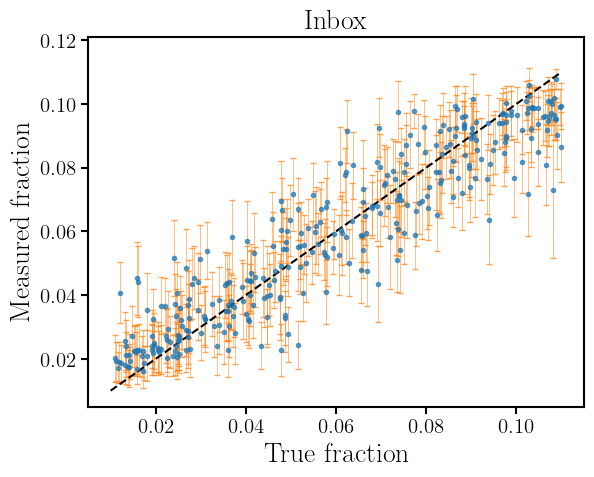

MSE error: 0.00011985874


In [57]:
plot_fraction(test, model, lenk=lenP, device=device, norm_fs=True, limits=[0.005, 0.121], title='Inbox', step=10)#, save='../figures/fraction-scatter-inbox-BSQ-P0B0-P0.png'

/tmp/ipykernel_51685/404757095.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.,0.6)


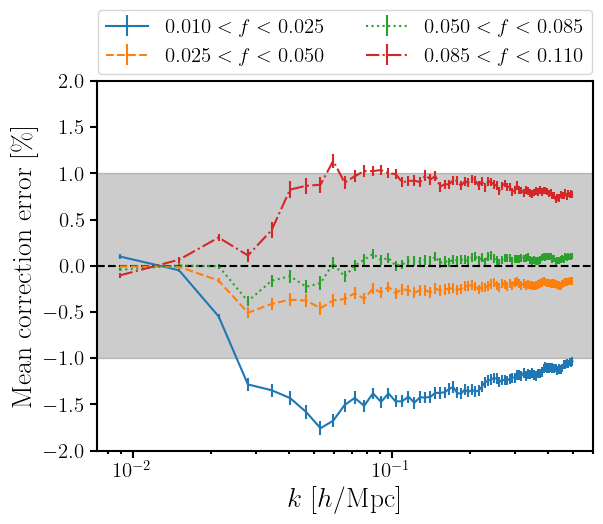

In [58]:
ks = np.loadtxt('ks-gris.dat')

p_mean1, y_mean1, std_mean1, m1, sm1, N1 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.001, 0.025, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean2, y_mean2, std_mean2, m2, sm2, N2 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.025, 0.050, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean3, y_mean3, std_mean3, m3, sm3, N3 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.050, 0.085, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean4, y_mean4, std_mean4, m4, sm4, N4 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.085, 0.110, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)

sel = (ks> 0.) & (ks < 0.5)
k_plot = ks[sel]

plt.errorbar(k_plot, m1[:lenk] * 100., yerr=sm1[:lenk]*100., label='$0.010 < f < 0.025$', linestyle='solid')
plt.errorbar(k_plot, m2[:lenk] * 100., yerr=sm2[:lenk]*100., label='$0.025 < f < 0.050$', linestyle='dashed')
plt.errorbar(k_plot, m3[:lenk] * 100., yerr=sm3[:lenk]*100., label='$0.050 < f < 0.085$', linestyle='dotted')
plt.errorbar(k_plot, m4[:lenk] * 100., yerr=sm4[:lenk]*100., label='$0.085 < f < 0.110$', linestyle='dashdot')

plt.axhline(0, color='k', linestyle='dashed')
plt.xscale('log')
plt.xlabel('$k$ [$h$/Mpc]')
plt.ylim(-2.,2.)
plt.xlim(0.,0.6)
plt.ylabel('''Mean correction error [$\\%$]''')

plt.fill_between([0., .6], -1, 1, alpha=.2, color='k')

plt.legend(ncols=2, loc='lower center', bbox_to_anchor=(0.5,0.99))
#plt.tight_layout()
#plt.savefig('../figures/MCE-inbox-BSQ-P0B0-P0-3P-ly2.pdf', bbox_inches='tight')
plt.show()


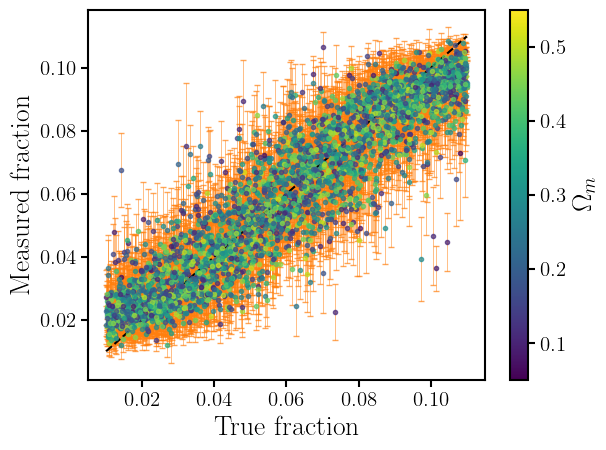

MSE error: 0.0001256674


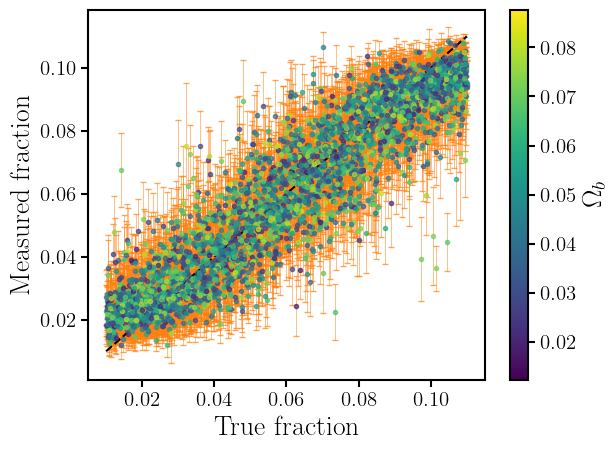

MSE error: 0.00012566741


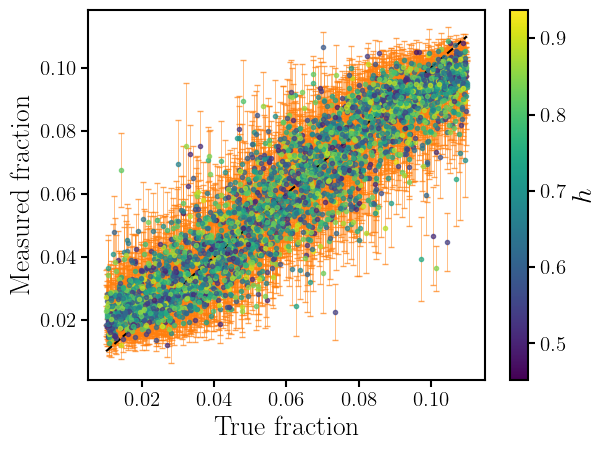

MSE error: 0.00012566741


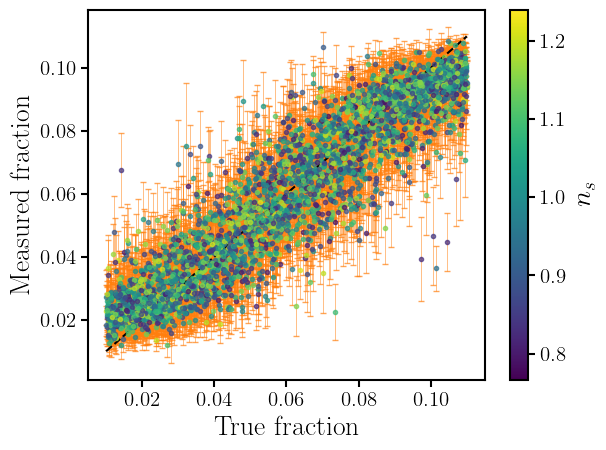

MSE error: 0.0001256674


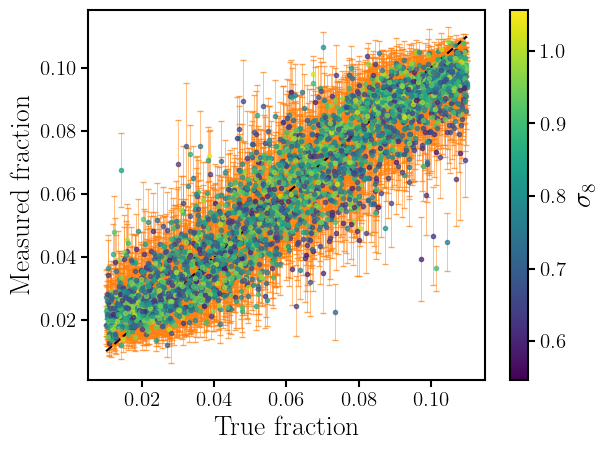

MSE error: 0.00012566741


In [59]:
plot_fraction_cosmocolor(test, model, lenk=lenk, device=device, cosmo_ind=-5, cosmo_name='$\\Omega_m$', norm_fs=True, save=None, max_corr=max_PBs, min_corr=min_PBs)
plot_fraction_cosmocolor(test, model, lenk=lenk, device=device, cosmo_ind=-4, cosmo_name='$\\Omega_b$', norm_fs=True, save=None, max_corr=max_PBs, min_corr=min_PBs)
plot_fraction_cosmocolor(test, model, lenk=lenk, device=device, cosmo_ind=-3, cosmo_name='$h$', norm_fs=True, save=None, max_corr=max_PBs, min_corr=min_PBs)
plot_fraction_cosmocolor(test, model, lenk=lenk, device=device, cosmo_ind=-2, cosmo_name='$n_s$', norm_fs=True, save=None, max_corr=max_PBs, min_corr=min_PBs)
plot_fraction_cosmocolor(test, model, lenk=lenk, device=device, cosmo_ind=-1, cosmo_name='$\\sigma_8$', norm_fs=True, save=None, max_corr=max_PBs, min_corr=min_PBs)


#### 5 Planck prior

I plot the fraction scatter for all the training set $N$ and the correction only for the largest one

In [60]:
for j in N:
    PBs, labels, lenP, lenB = NINf.load_PBf("inbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, n_load=j)
    print(lenP, lenB)
    max_corr = labels[:,:-1].max(axis=0)
    min_corr = labels[:,:-1].min(axis=0)
    
    PBs, labels, lenP, lenB = NINf.load_PBf("inbox_all-fs-RSD-BSQ.csv", "fractions-BSQ.txt", k_max=.5, log=False, norm_fs=True, norm_c=True, n_load=j)
    
    ##Priors
    Pk_paths = pd.read_csv("outbox_all-fs-RSD-BSQ.csv")
    
    sP = {'sigma_8': 0.0060, 'Omega_m': 0.0056, 'h': 0.0042, 'n_s': 0.0038, 'Omega_b': 0.0008} #from Table 2 in Planck 2018 (1807.06209)
    priors = ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
    len_priors = len(priors)
    np.random.seed(j) #for reproducibility of the MSE and plots
    r = np.random.normal(size=(len(PBs), len_priors))
    cosmo_p = np.zeros((len(PBs), len_priors))
    
    for i, prior in enumerate(priors):
        if len_priors == 1:
            cosmo_p = np.reshape(Pk_paths[prior],((len(PBs),1))) + r * sP[prior] * 5. #5 times Planck
        else:
            cosmo_p[:,i] = Pk_paths[prior][:j] + r[:,i] * sP[prior] * 5. #5 times Planck
    
    #print(cosmo_p)
    
    PBs = np.hstack((PBs, cosmo_p)) #I also normalize cosmo_p between 0 and 1
    #Loading max min
    
    n = f'NoInterNet-Logloss-P0B0-P0-allprior5P-{j:d}-moments' if j != 2**15 else 'NoInterNet-Logloss-P0B0-P0-allprior5P-BSQ-moments'

    min_PBs, max_PBs = np.loadtxt("../trained-model/BSQ/RSD/inbox/" + n + "/maxmin.dat", unpack=True)
    PBs = NINf.maxmin_corr(PBs, max_PBs, min_PBs)
    norm = np.ones(len(PBs))
    
    fs = labels[:,-1]
    
    _, ind = np.unique(fs, return_index=True)
    f_u = np.array([fs[indx] for indx in sorted(ind)]) #non ordered unique interloper fraction array
    
    n_train = int(len(f_u)*0.75)
    n_val = int(len(f_u)*0.9)
    
    fs_test = (f_u[n_val:])
    
    sel_test = np.array([], dtype=int)
    
    for f in fs_test: sel_test= np.append(sel_test, np.where(fs == f)[0])
    
    PBs_test = PBs[sel_test]
    labels_test = labels[sel_test]
    
    norm_test = np.array(norm[sel_test, np.newaxis])
    
    test = NIN.PkDataset(PBs_test, labels_test, norm_test)
    
    test_batch = 10
    test_dataloader = DataLoader(test, batch_size=test_batch, shuffle=True)

    model = NINf.NoInterNet_fraction_compress_inference(lenP+lenB+5, 64, lenP, 64, n_min=16).to(device)
    NIN.resume(model, "../trained-model/BSQ/RSD/inbox/" + n + "/best_model-64.pth", device)

    print(j)
    #plot_fraction(test, model, lenk=lenP, device=device, norm_fs=True, save=None)
    chi2(test, model, lenk=lenP, device=device, norm_fs=True, thresh=1e-3)
    

79 294
1 64 32
2 32 16
3 16 32
4 32 64
512
0
Reduced chi2: 0.9844579696655273


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
1024
0
Reduced chi2: 3.8570915148096176


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
2048
0
Reduced chi2: 1.8623338652820123


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
4096
0
Reduced chi2: 2.0312613138338413


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
8192
0
Reduced chi2: 1.7917149985708842


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
16384
1
Reduced chi2: 1.1716345833015558


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

79 294
1 64 32
2 32 16
3 16 32
4 32 64
32768
2
Reduced chi2: 1.3312138221887397


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

/tmp/ipykernel_51685/3810797402.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.,0.6)


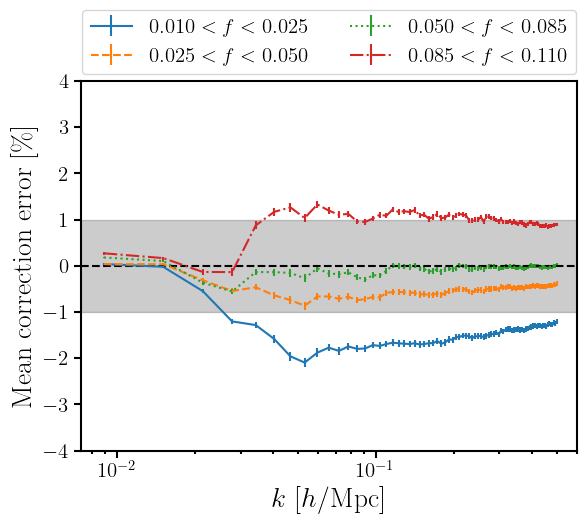

In [61]:
ks = np.loadtxt('ks-gris.dat')

p_mean1, y_mean1, std_mean1, m1, sm1, N1 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.001, 0.025, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean2, y_mean2, std_mean2, m2, sm2, N2 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.025, 0.050, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean3, y_mean3, std_mean3, m3, sm3, N3 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.050, 0.085, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean4, y_mean4, std_mean4, m4, sm4, N4 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.085, 0.110, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)

sel = (ks> 0.) & (ks < 0.5)
k_plot = ks[sel]

plt.errorbar(k_plot, m1[:lenk] * 100., yerr=sm1[:lenk]*100., label='$0.010 < f < 0.025$', linestyle='solid')
plt.errorbar(k_plot, m2[:lenk] * 100., yerr=sm2[:lenk]*100., label='$0.025 < f < 0.050$', linestyle='dashed')
plt.errorbar(k_plot, m3[:lenk] * 100., yerr=sm3[:lenk]*100., label='$0.050 < f < 0.085$', linestyle='dotted')
plt.errorbar(k_plot, m4[:lenk] * 100., yerr=sm4[:lenk]*100., label='$0.085 < f < 0.110$', linestyle='dashdot')

plt.axhline(0, color='k', linestyle='dashed')
plt.xscale('log')
plt.xlabel('$k$ [$h$/Mpc]')
plt.ylim(-4.,4.)
plt.xlim(0.,0.6)
plt.ylabel('''Mean correction error [$\\%$]''')

plt.fill_between([0., .6], -1, 1, alpha=.2, color='k')

plt.legend(ncols=2, loc='lower center', bbox_to_anchor=(0.5,0.99))
#plt.tight_layout()
plt.show()

## MSE comparison

MSE results tables: all the results use the whole BSQ

Inbox: fixed cosmology 

P0 -> P0 MSE = $1.30 \times 10^{-5}$

P0B0 -> P0 MSE = $9.91 \times 10^{-6}$

|Priors     |P0 |P0B0|
|:----------|:--|:---|
|Cosmo known|$4.88 \times 10^{-5}$|$3.77 \times 10^{-5}$|
|1 Planck   |$1.05 \times 10^{-4}$|$8.17 \times 10^{-5}$|
|3 Planck   |$1.75 \times 10^{-4}$|$1.26 \times 10^{-4}$|
|5 Planck   |$2.29 \times 10^{-4}$|$1.58 \times 10^{-4}$|

/tmp/ipykernel_51685/1921637637.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogy(P,P0B0,'-s',label='P0B0', linestyle='dashed')


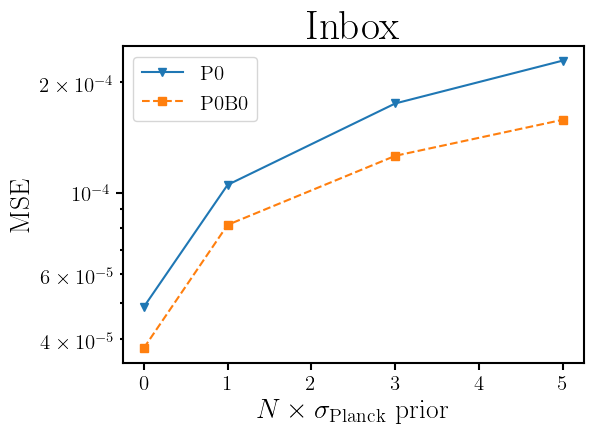

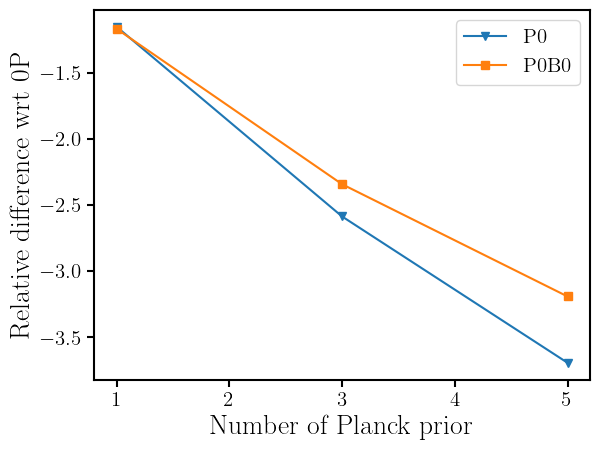

In [62]:
P = np.array([0,1,3,5])
P0 = np.array([4.88e-5, 1.05e-4, 1.75e-4, 2.29e-4])
P0B0 = np.array([3.77e-5, 8.17e-5, 1.26e-4, 1.58e-4])

plt.semilogy(P,P0,'-v',label='P0')
plt.semilogy(P,P0B0,'-s',label='P0B0', linestyle='dashed')

plt.legend()
plt.xlabel('''$N \\times \\sigma_{\\rm Planck}$ prior''')
plt.ylabel('MSE')
plt.title('Inbox')

plt.tight_layout()
#plt.savefig('../figures/MSE-NP-BSQ-inbox.pdf')


plt.show()

plt.plot(P[1:], 1 - P0[1:]/P0[0], '-v', label='P0')
plt.plot(P[1:], 1 - P0B0[1:]/P0B0[0], '-s', label='P0B0')

plt.legend()
plt.xlabel('''Number of Planck prior''')
plt.ylabel('Relative difference wrt 0P')

plt.show()

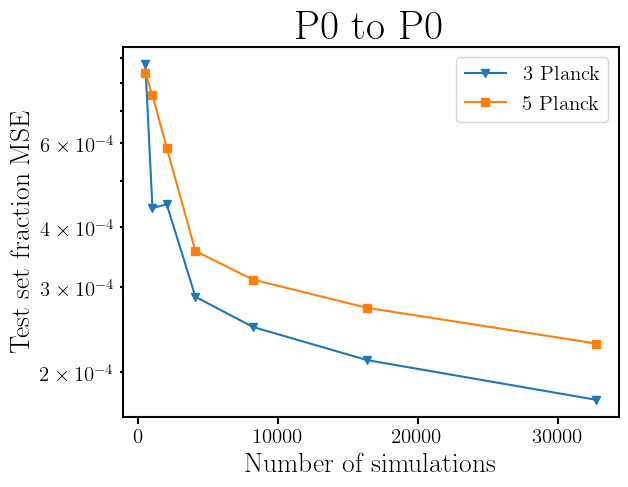

In [63]:
MSE_P0_3P = np.array([0.000876762, 0.00043893096, 0.0004464216, 0.0002865793, 0.00024800, 0.00021143582, 0.00017476936])

MSE_P0_5P = np.array([0.0008398349, 0.0007530413, 0.000585308, 0.00035701657, 0.0003112765, 0.0002717325, 0.00022897897])

plt.semilogy(N, MSE_P0_3P, '-v', label='3 Planck')
plt.semilogy(N, MSE_P0_5P, '-s', label='5 Planck')

plt.xlabel('Number of simulations')
plt.ylabel('Test set fraction MSE')

plt.title('P0 to P0')
plt.legend()

plt.show()

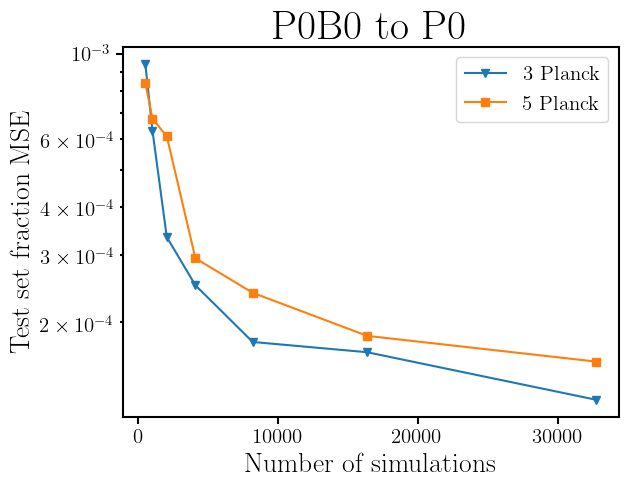

In [64]:
MSE_P0B0_3P = np.array([0.00094298925, 0.00063135393, 0.00033346968, 0.00024978185, 0.00017777485, 0.0001671535, 0.0001256674])

MSE_P0B0_5P = np.array([0.00084184675, 0.0006783489, 0.0006101927, 0.0002936008, 0.00023878348, 0.00018439753, 0.00015799575])

plt.semilogy(N, MSE_P0B0_3P, '-v', label='3 Planck')
plt.semilogy(N, MSE_P0B0_5P, '-s', label='5 Planck')

plt.xlabel('Number of simulations')
plt.ylabel('Test set fraction MSE')

plt.title('P0B0 to P0')
plt.legend()

plt.show()

/tmp/ipykernel_51685/4230383206.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-v" (-> linestyle='-'). The keyword argument will take precedence.
  plt.loglog(N, MSE_P0B0_3P, '-v', label='$3 \\times \\sigma_{\\rm Planck}$ $P_0 + B_0$', linestyle='dashed')
/tmp/ipykernel_51685/4230383206.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  plt.loglog(N, MSE_P0B0_5P, '-s', label='$5 \\times \\sigma_{\\rm Planck}$ $P_0 + B_0$', linestyle='dashed')


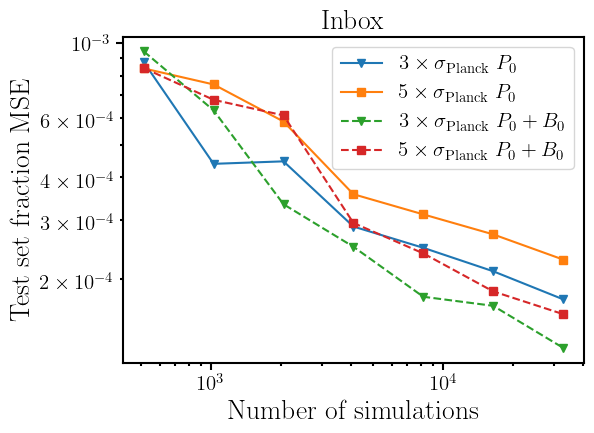

In [65]:
plt.loglog(N, MSE_P0_3P, '-v', label='$3 \\times \\sigma_{\\rm Planck}$ $P_0$')
plt.loglog(N, MSE_P0_5P, '-s', label='$5 \\times \\sigma_{\\rm Planck}$ $P_0$')

plt.loglog(N, MSE_P0B0_3P, '-v', label='$3 \\times \\sigma_{\\rm Planck}$ $P_0 + B_0$', linestyle='dashed')
plt.loglog(N, MSE_P0B0_5P, '-s', label='$5 \\times \\sigma_{\\rm Planck}$ $P_0 + B_0$', linestyle='dashed')

plt.xlabel('Number of simulations')
plt.ylabel('Test set fraction MSE')


plt.title('Inbox', size=20)
plt.legend()

plt.tight_layout()
#plt.savefig('../figures/MSE-N-BSQ-inbox.pdf')

plt.show()